In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns

from gwbird import detectors
from gwbird.skymap import Basis, Skymaps
from gwbird import pls
from gwbird.overlap import Response
from gwbird.nell import AngularResponse, Sensitivity_ell
from gwbird import nell
from gwbird.utils import c, H0, h
import beepy

%config InlineBackend.figure_format = 'retina'

sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Antenna Pattern maps

Antenna pattern function: detector response to an incoming GW signal

Parameters:

- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: frequency array

- psi: polarization angle in [0, pi]

- pol: polarization type: 't', 'v', 's', 'I', 'V'

- nside: int, optional\
    The nside parameter for the healpy function. Default is 32.

- shift_angle: float, optional\
    The separation angle between ET L Sardinia - ET L The Netherlands. Default is None.

Returns:
overlap_map: overlap map, array of shape (npix,)


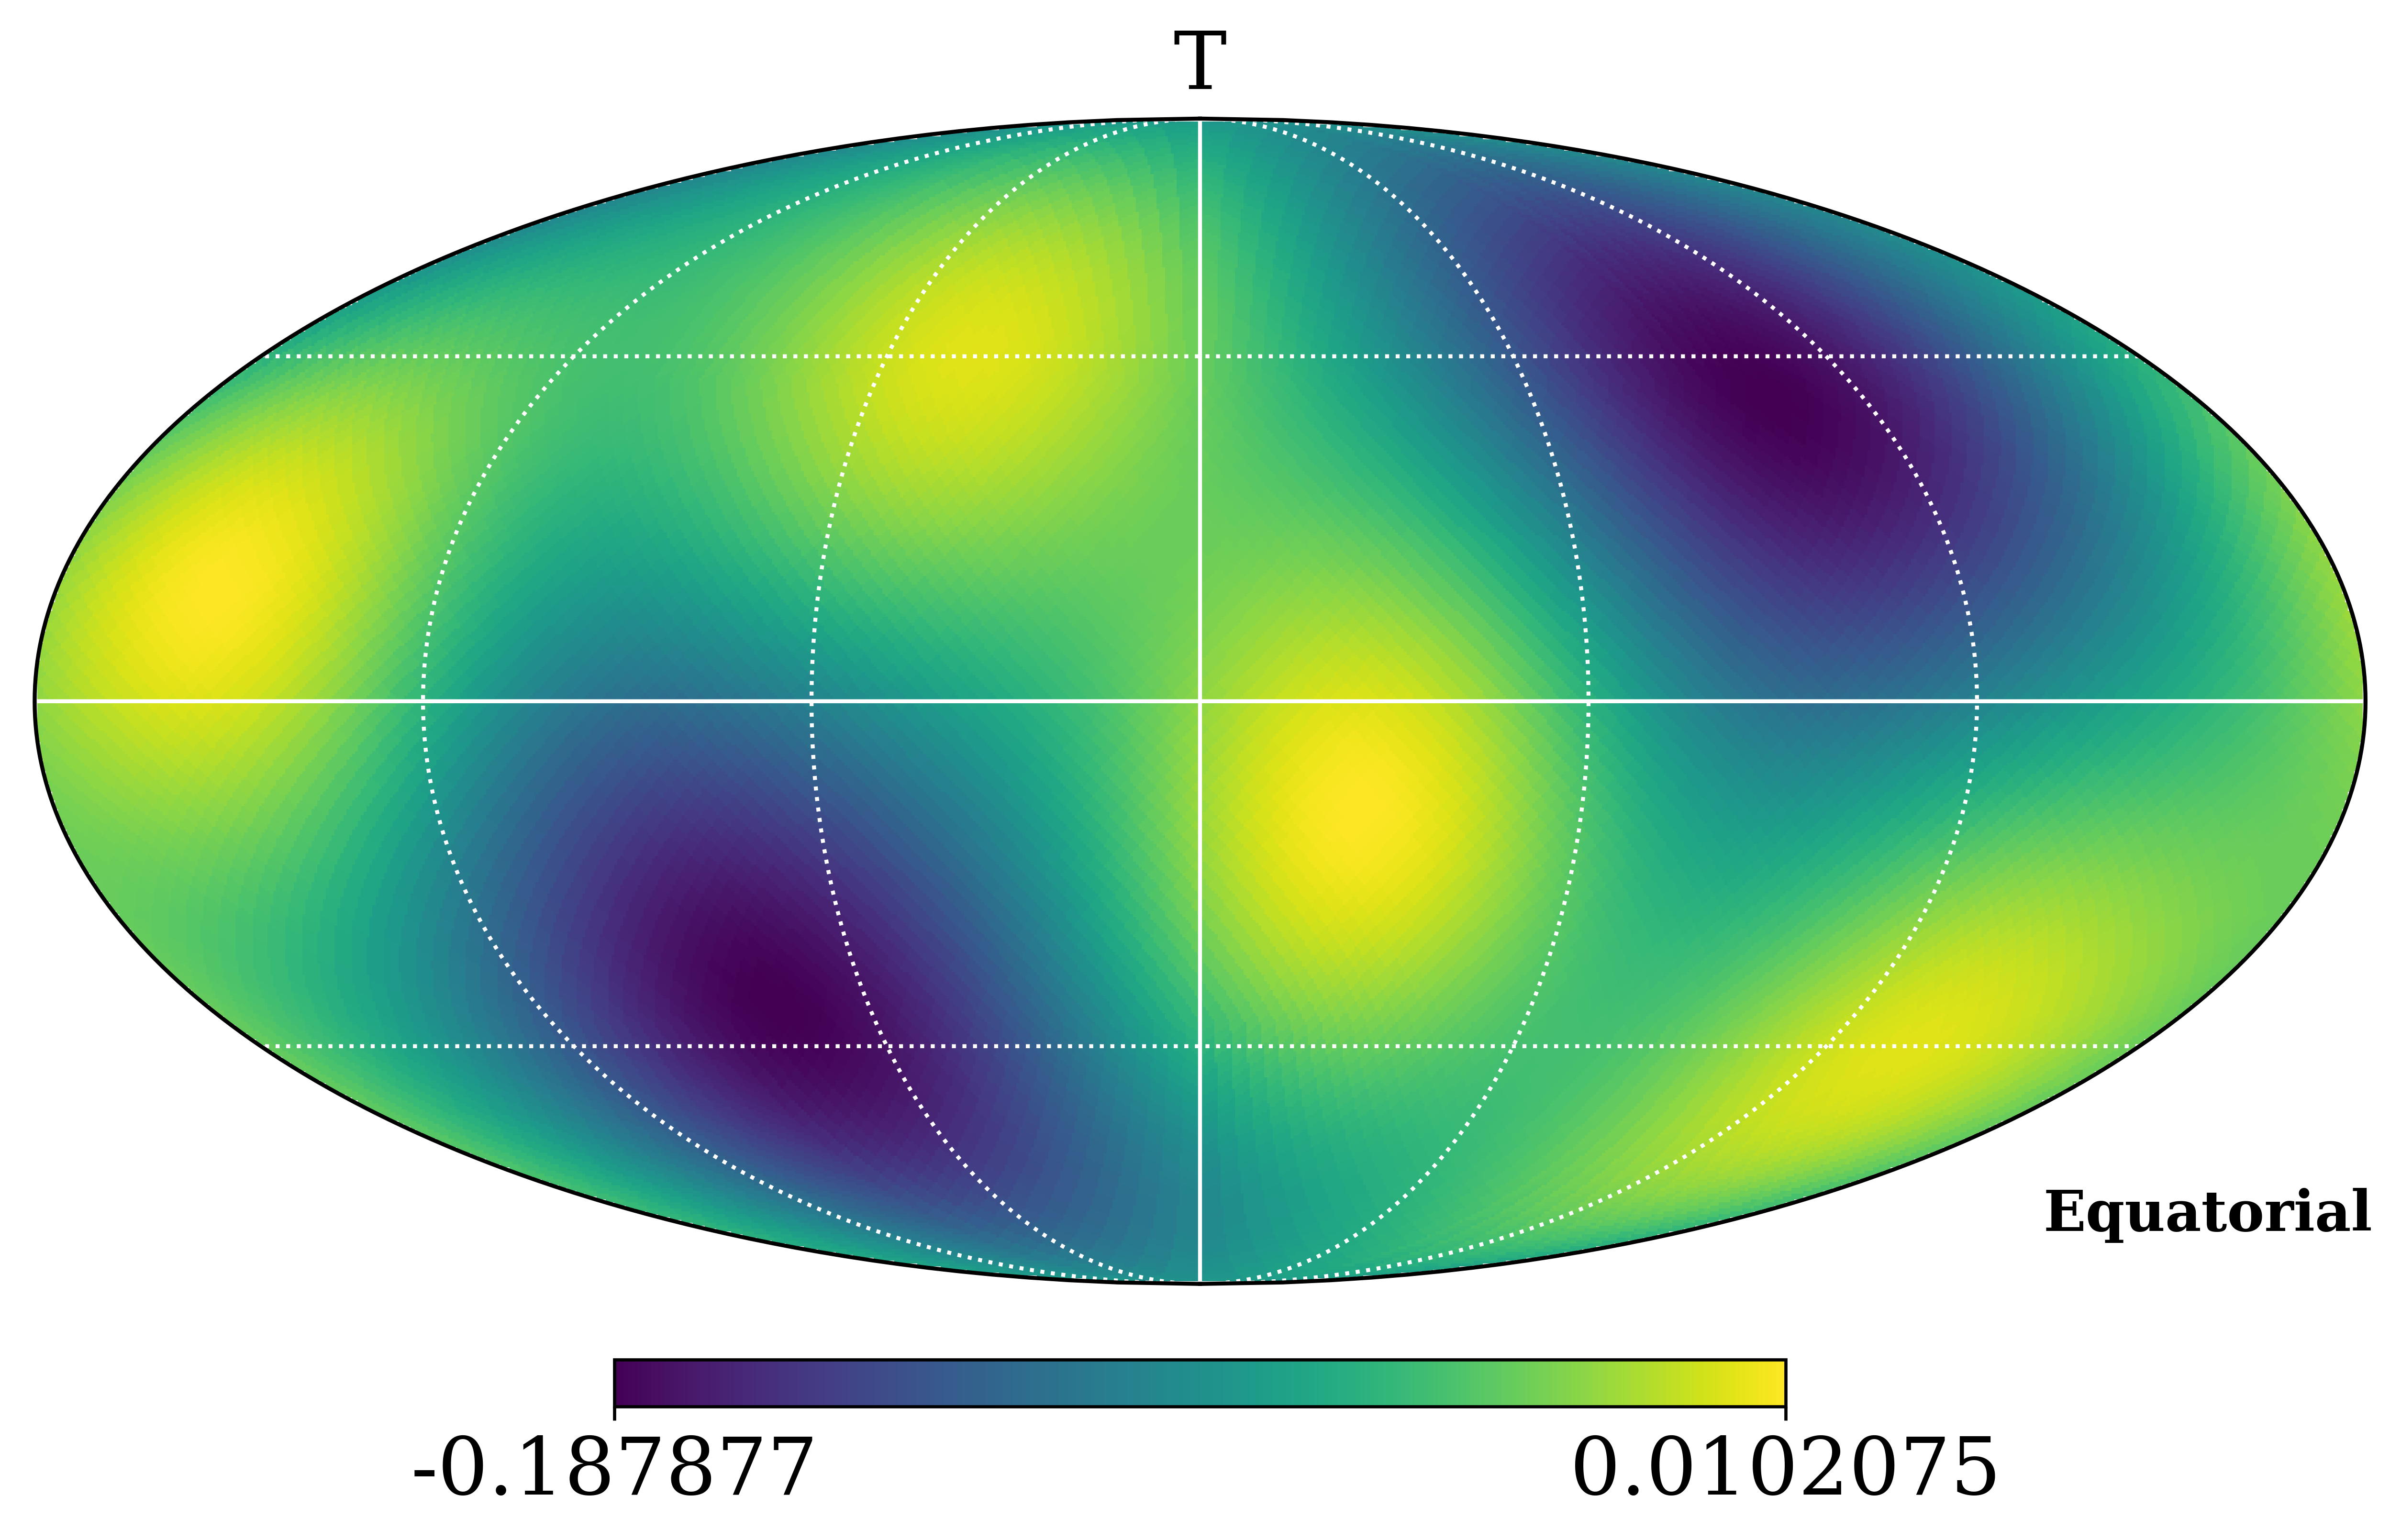

In [69]:
mapHL = Skymaps.AntennaPattern('LIGO H', 'LIGO L', 10, 0, 't')
beepy.beep(sound=1) 

# Overlap reduction function

## Ground Based Detectors


Calculate the overlap response between two detectors.

R = Response.overlap(det1, det2, f, psi, pol, shift_angle=False)

Parameters:
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- psi: float (Polarization angle in radians)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for tensor intensity stokes parameter, 'V' for tensor circular polarization stokes parameter )

Optional parameters:
- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)



['LIGO H', 'LIGO L', 'Virgo', 'KAGRA', 'CE', 'ET X', 'ET Y', 'ET Z', 'ET A', 'ET E', 'ET T', 'ET L1', 'ET L2', 'LISA X', 'LISA Y', 'LISA Z', 'LISA A', 'LISA E', 'LISA T']


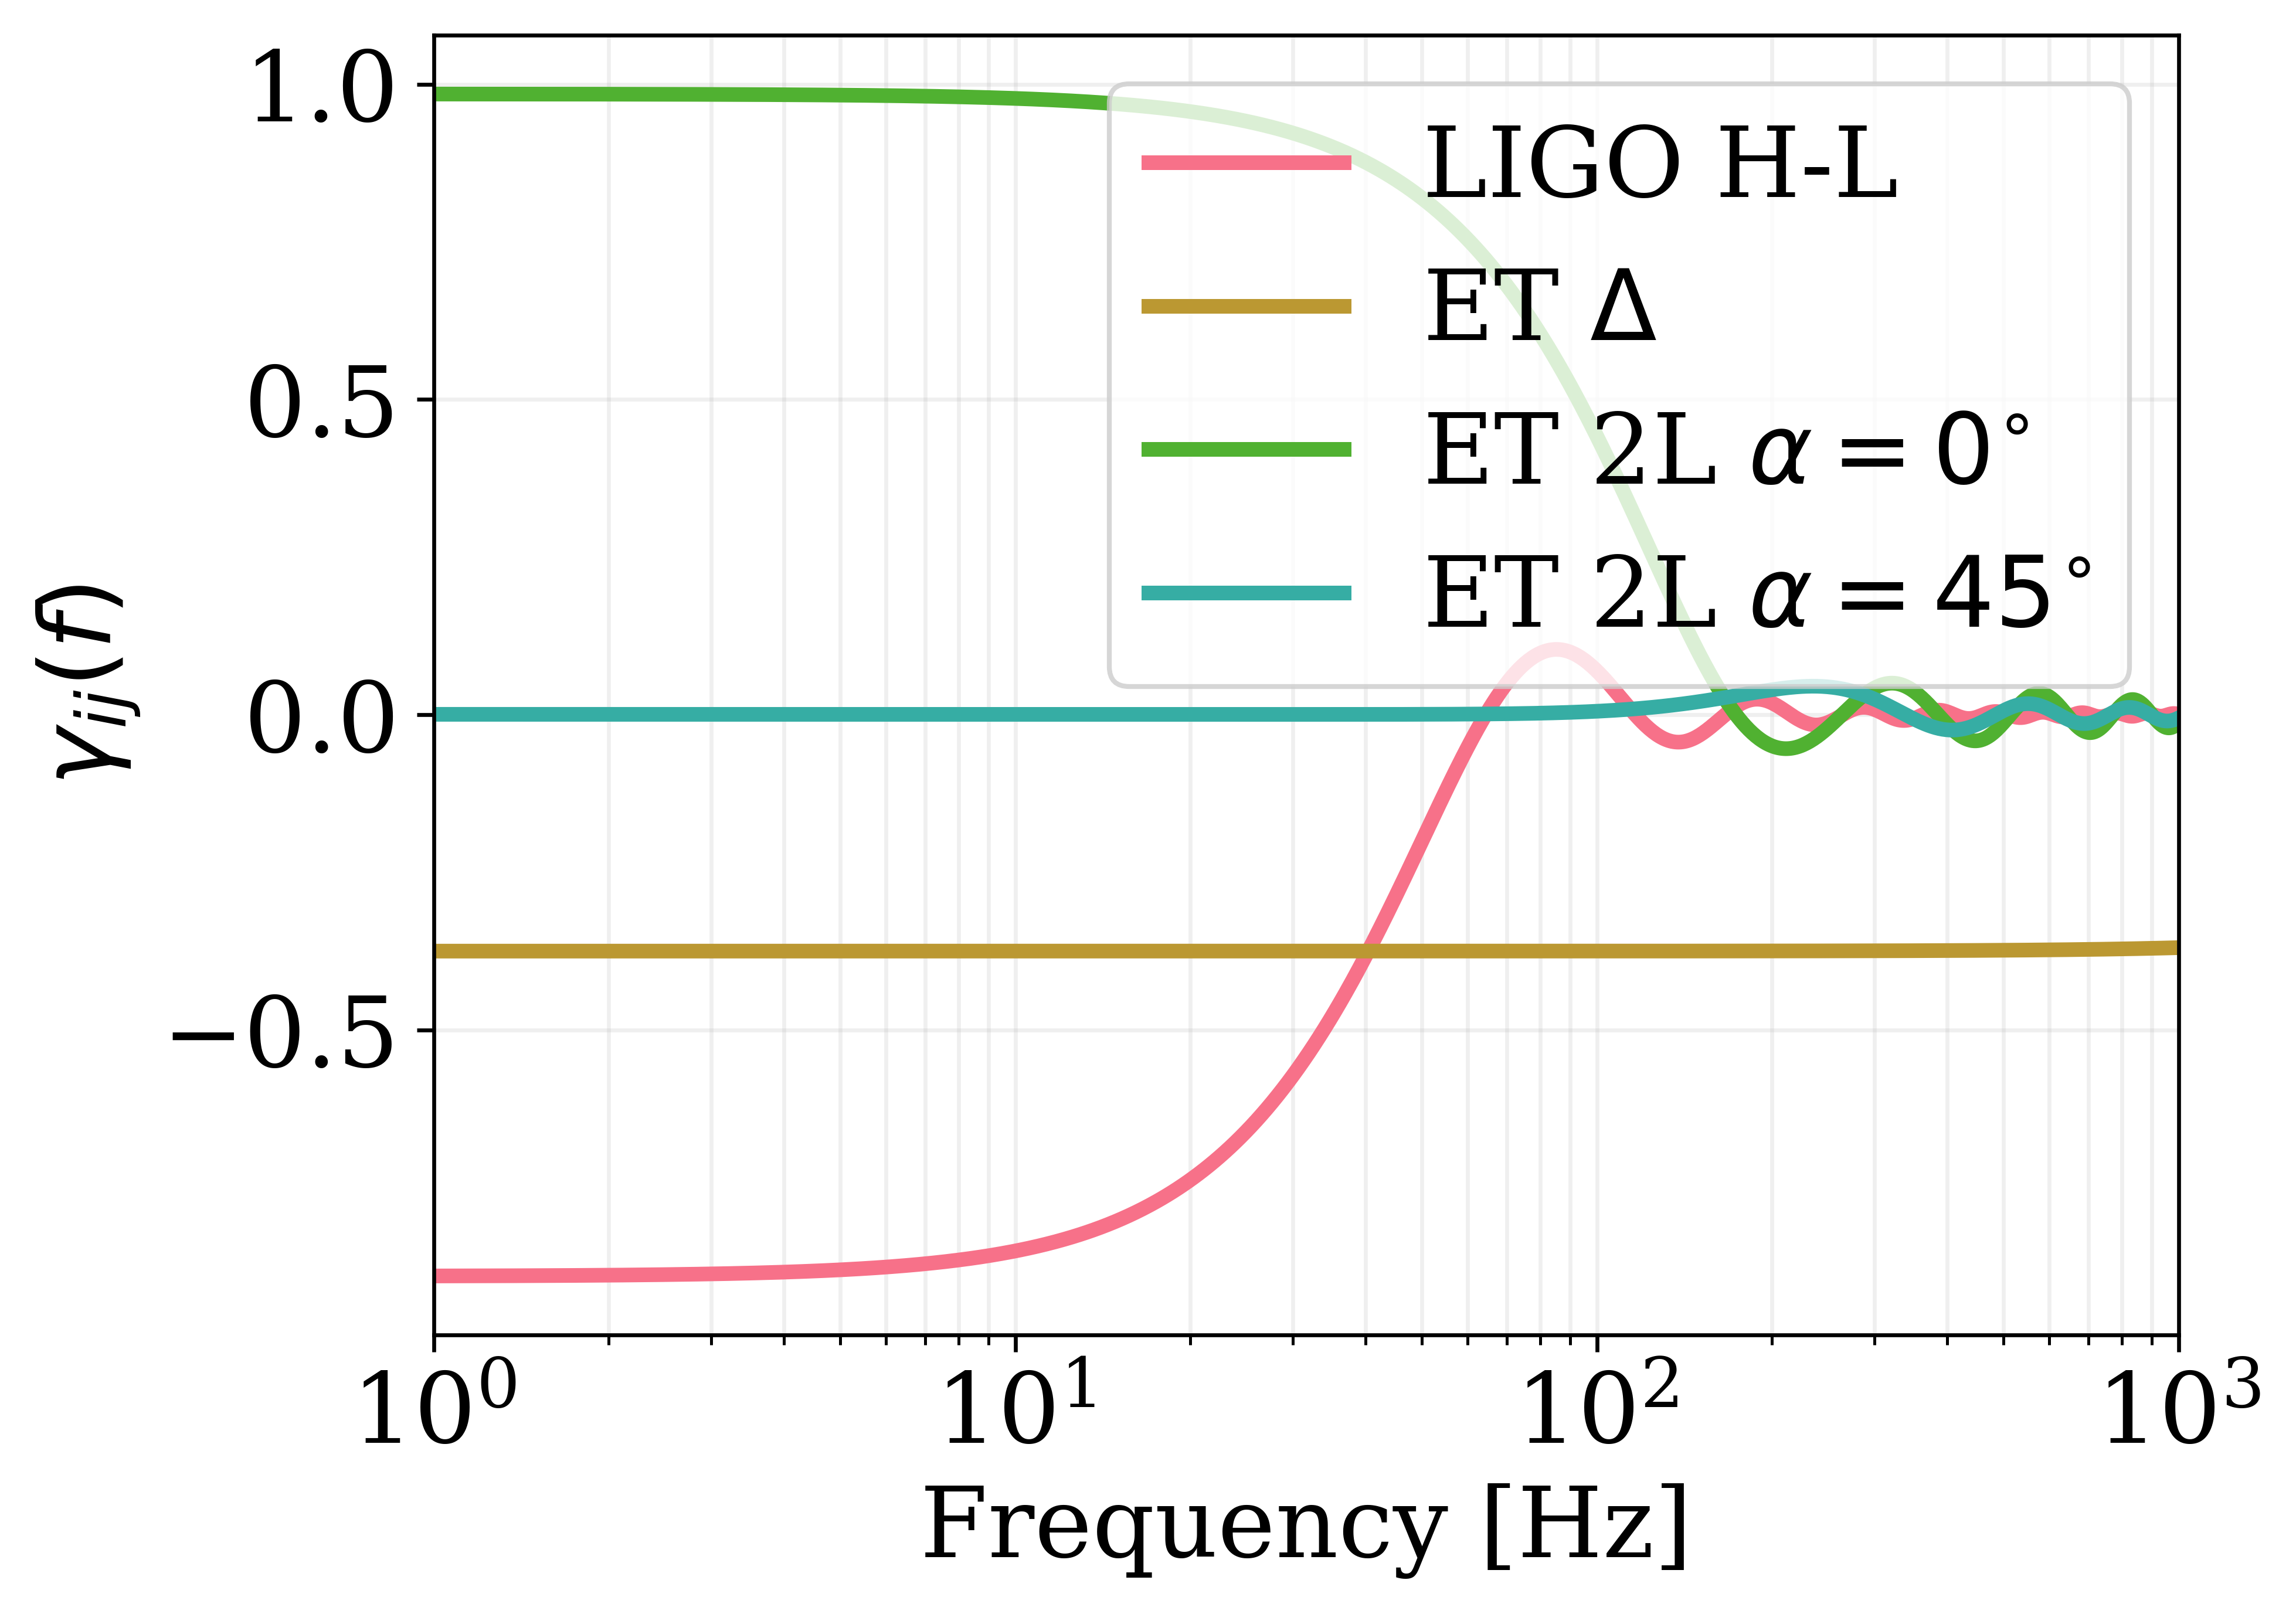

In [72]:
print(detectors.available_detectors())

f = np.logspace(0, 3, 1000)
R_LIGO = Response.overlap('LIGO H', 'LIGO L', f, 0, 't', None)
R_ET = Response.overlap('ET X', 'ET Y', f, 0, 't', None)
R_ET2L0 = Response.overlap('ET L1', 'ET L2', f, 0, 't', shift_angle=0)
R_ET2L45 = Response.overlap('ET L1', 'ET L2', f, 0, 't', shift_angle=np.pi/4)
beepy.beep(sound=1) 

plt.plot(f, R_LIGO, label='LIGO H-L')
plt.plot(f, R_ET, label=r'ET $\Delta$')
plt.plot(f, R_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, R_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2) 
plt.legend() 


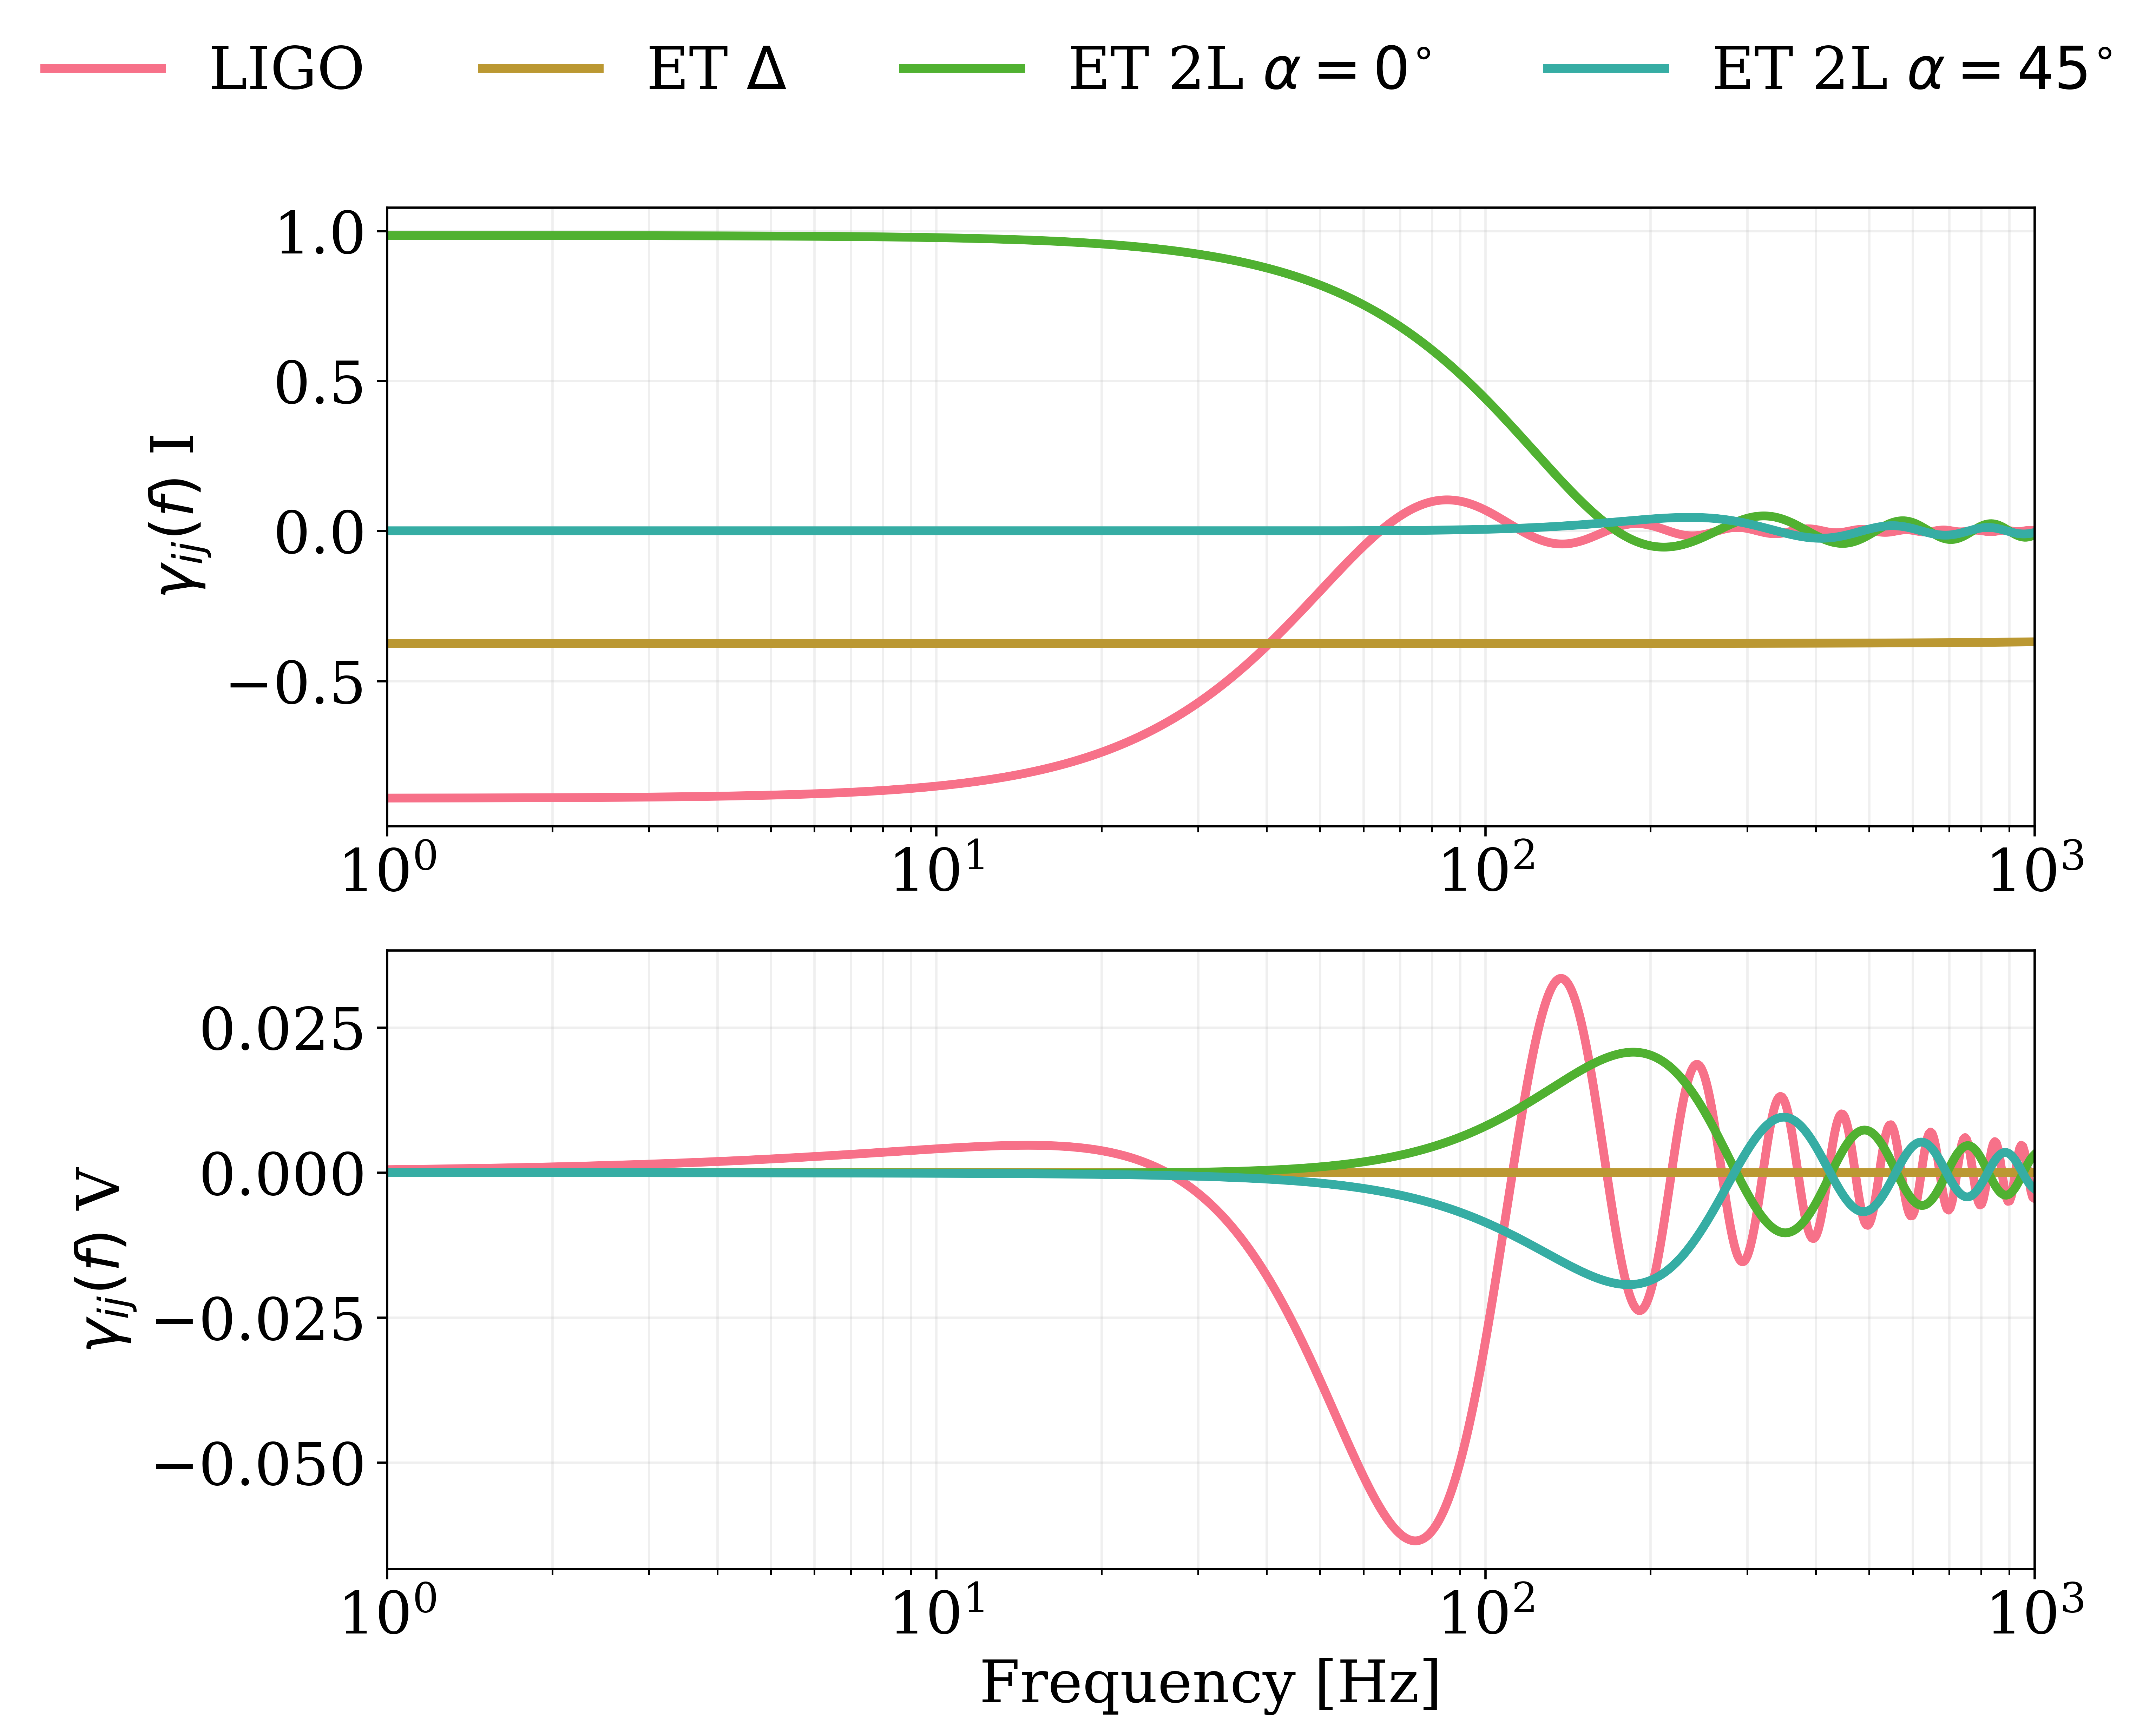

In [73]:
# example of the overlap function for the I and V stokes parameter

R_LIGO_I = Response.overlap('LIGO H', 'LIGO L', f, 0, 'I', None)
R_LIGO_V = Response.overlap('LIGO H', 'LIGO L', f, 0, 'V', None)
R_ET_I    = Response.overlap('ET X', 'ET Y', f, 0, 'I', None)
R_ET_V    = Response.overlap('ET X', 'ET Y', f, 0, 'V', None)
R_ET2L0_I = Response.overlap('ET L1', 'ET L2', f, 0, 'I', shift_angle=0)
R_ET2L0_V = Response.overlap('ET L1', 'ET L2', f, 0, 'V', shift_angle=0)
R_ET2L45_I = Response.overlap('ET L1', 'ET L2', f, 0, 'I', shift_angle=np.pi/4)
R_ET2L45_V = Response.overlap('ET L1', 'ET L2', f, 0, 'V', shift_angle=np.pi/4)

beepy.beep(sound=1) 

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)

plt.plot(f, R_LIGO_I, label='LIGO')
plt.plot(f, R_ET_I, label=r'ET $\Delta$')
plt.plot(f, R_ET2L0_I, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, R_ET2L45_I, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$ I')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)

plt.subplot(2, 1, 2)
plt.plot(f, R_LIGO_V)
plt.plot(f, R_ET_V)
plt.plot(f, R_ET2L0_V)
plt.plot(f, R_ET2L45_V)
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$ V')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)


lines_labels = [ax.get_legend_handles_labels() for ax in plt.gcf().axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

intensity_labels = ['LIGO', r'ET $\Delta$', r'ET 2L $\alpha=0^{\circ}$', r'ET 2L $\alpha=45^{\circ}$']
filtered_lines_labels = [(line, label) for line, label in zip(lines, labels) if label in intensity_labels]

if filtered_lines_labels:
    lines, labels = zip(*filtered_lines_labels)
else:
    lines, labels = [], []

if lines and labels:
    plt.figlegend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## LISA

For triangular detector, like ET and LISA, it is available to consider their combination in the AET basis. 

You can type 'ET' or 'LISA' + space + 'A', 'E', 'T'.

Invalid combination of channels are properly handled. 

* Note: we do not adopt the convention by which $\gamma_{ij}$ is normalized by $1/4\pi$ for LISA but we normalize it as all the other detectors to $5/8\pi$

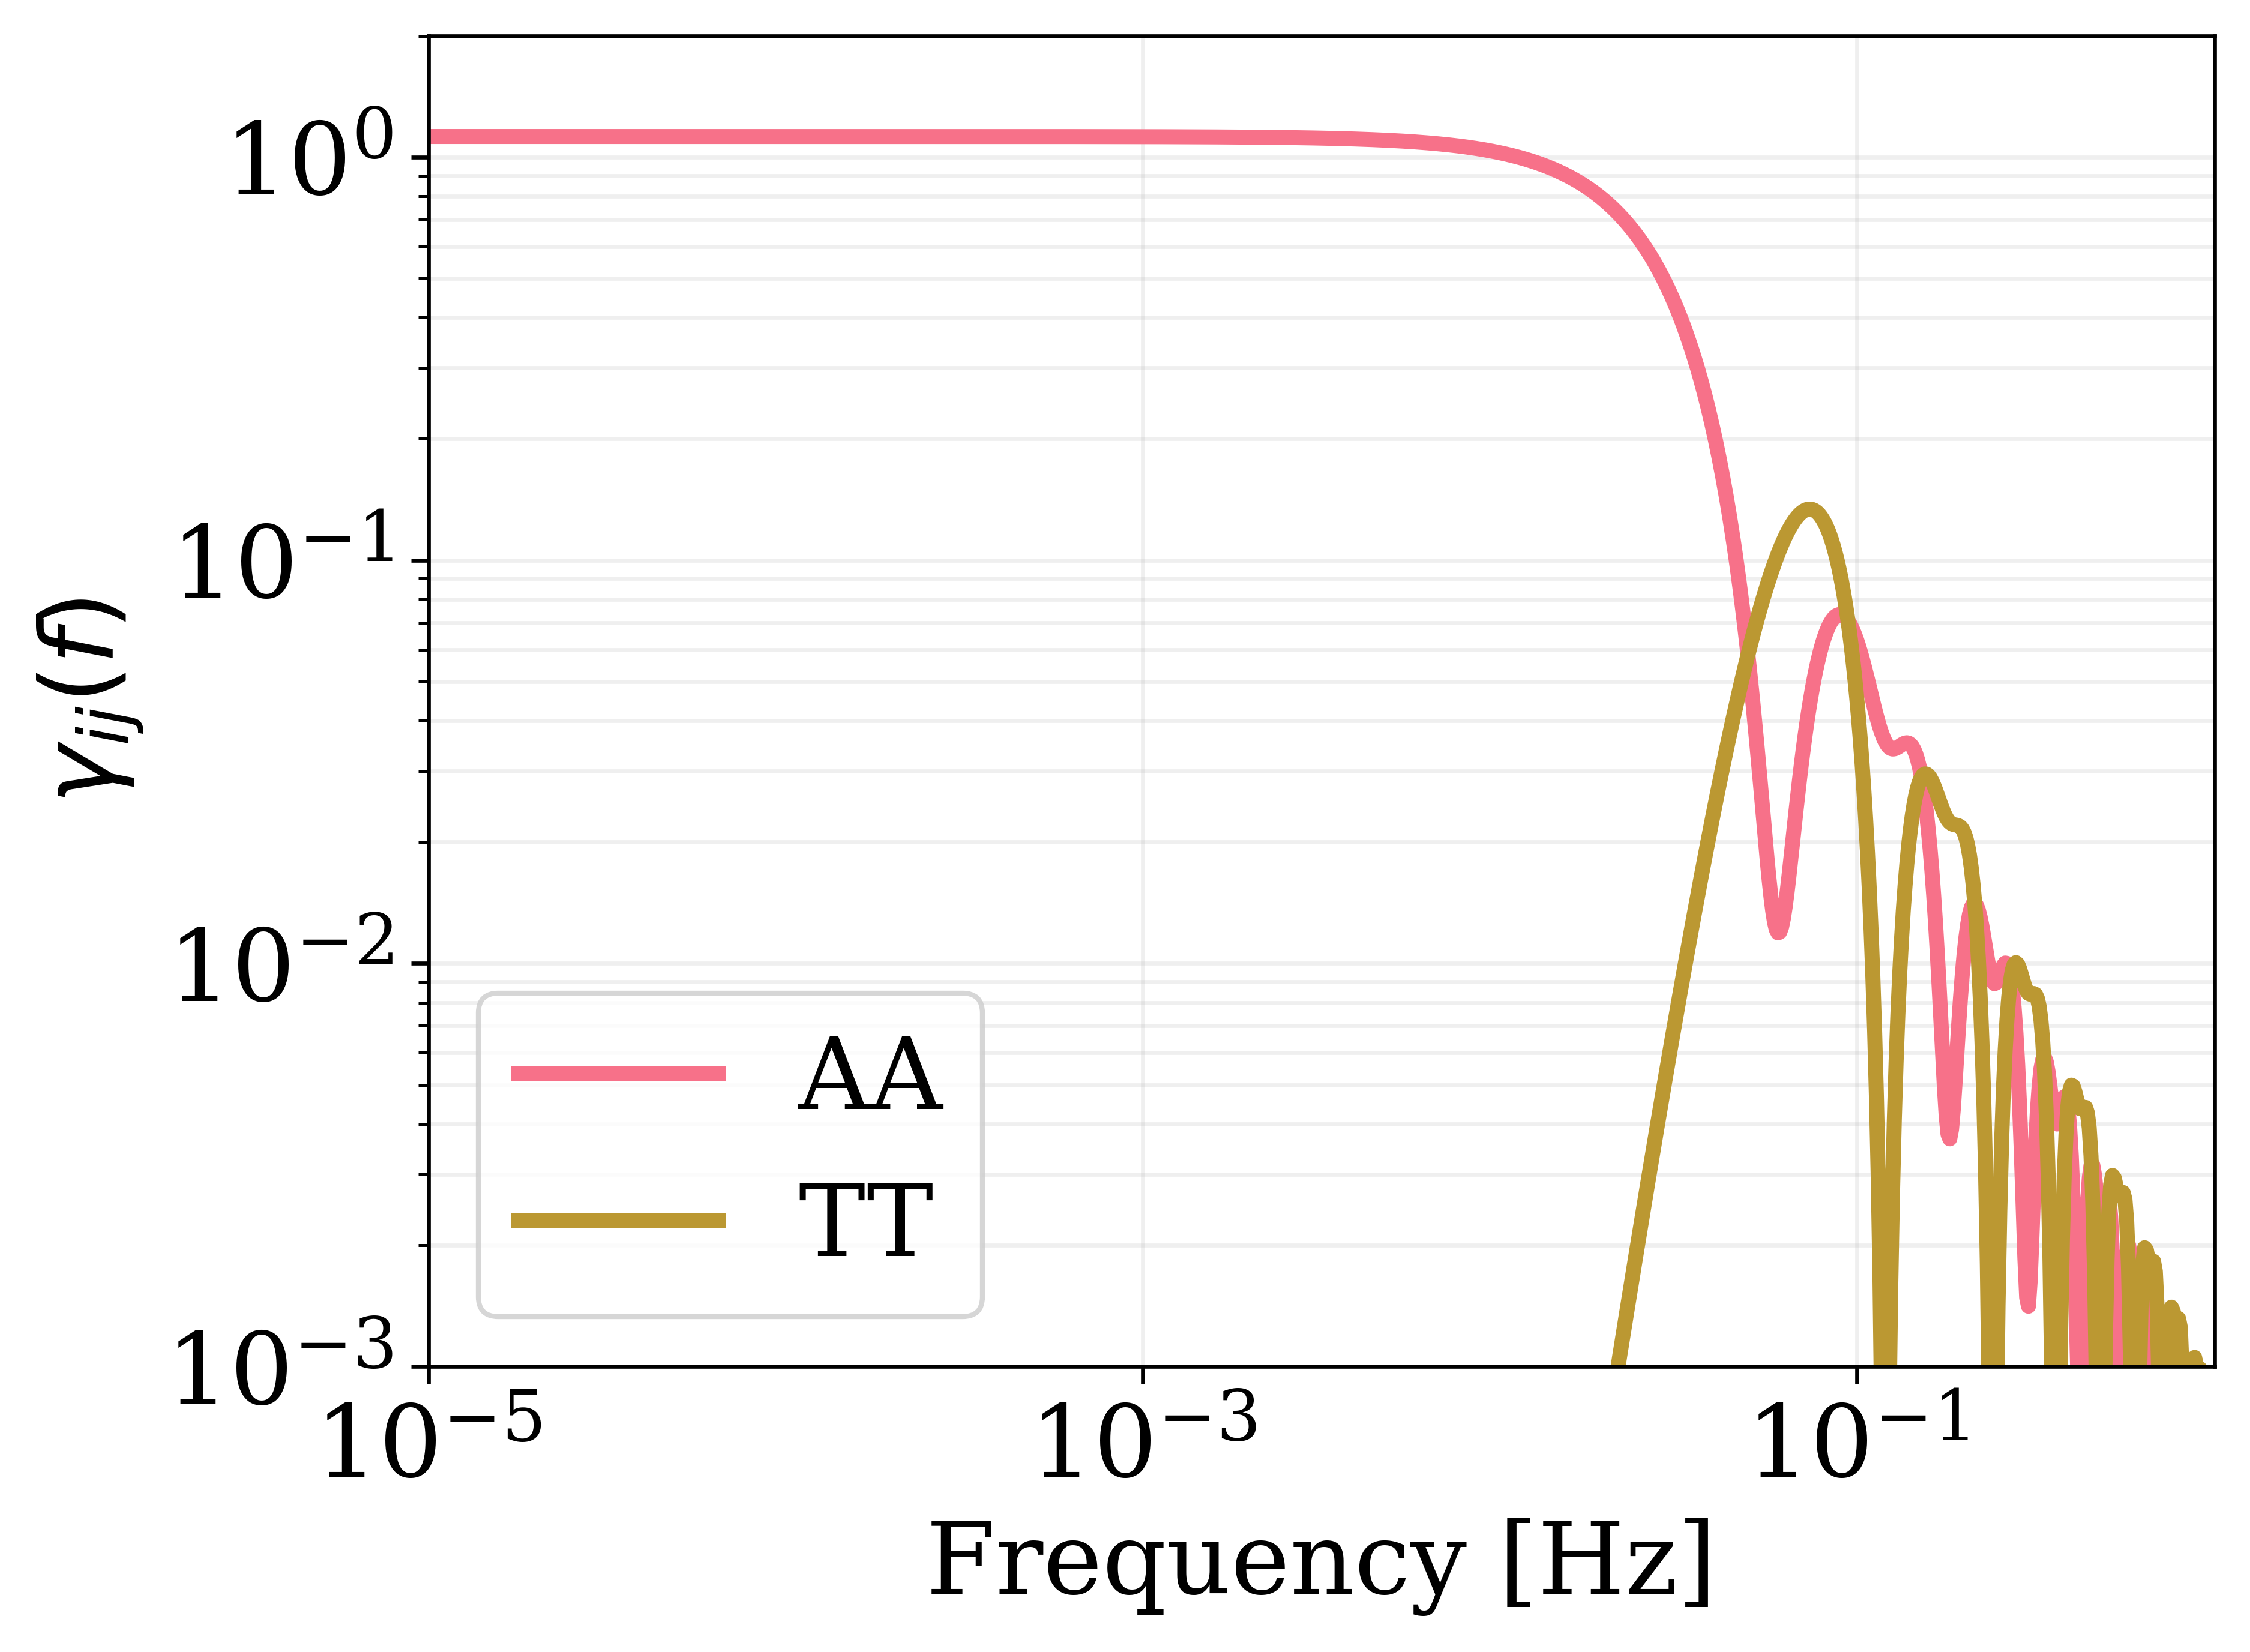

In [74]:
f_lisa = np.logspace(-5, 0, 1000)
R_AA = Response.overlap('LISA A', 'LISA A', f_lisa, 0, 't')
R_TT = Response.overlap('LISA T', 'LISA T', f_lisa, 0, 't')
beepy.beep(sound=1) 

plt.figure()
plt.plot(f_lisa, R_AA, label='AA')
plt.plot(f_lisa, R_TT, label='TT')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.ylim(1e-3, 2)
plt.grid(which='both', alpha=0.2)
plt.legend()

# Pulsar Timing Array

2025-03-12 11:48:12.653 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


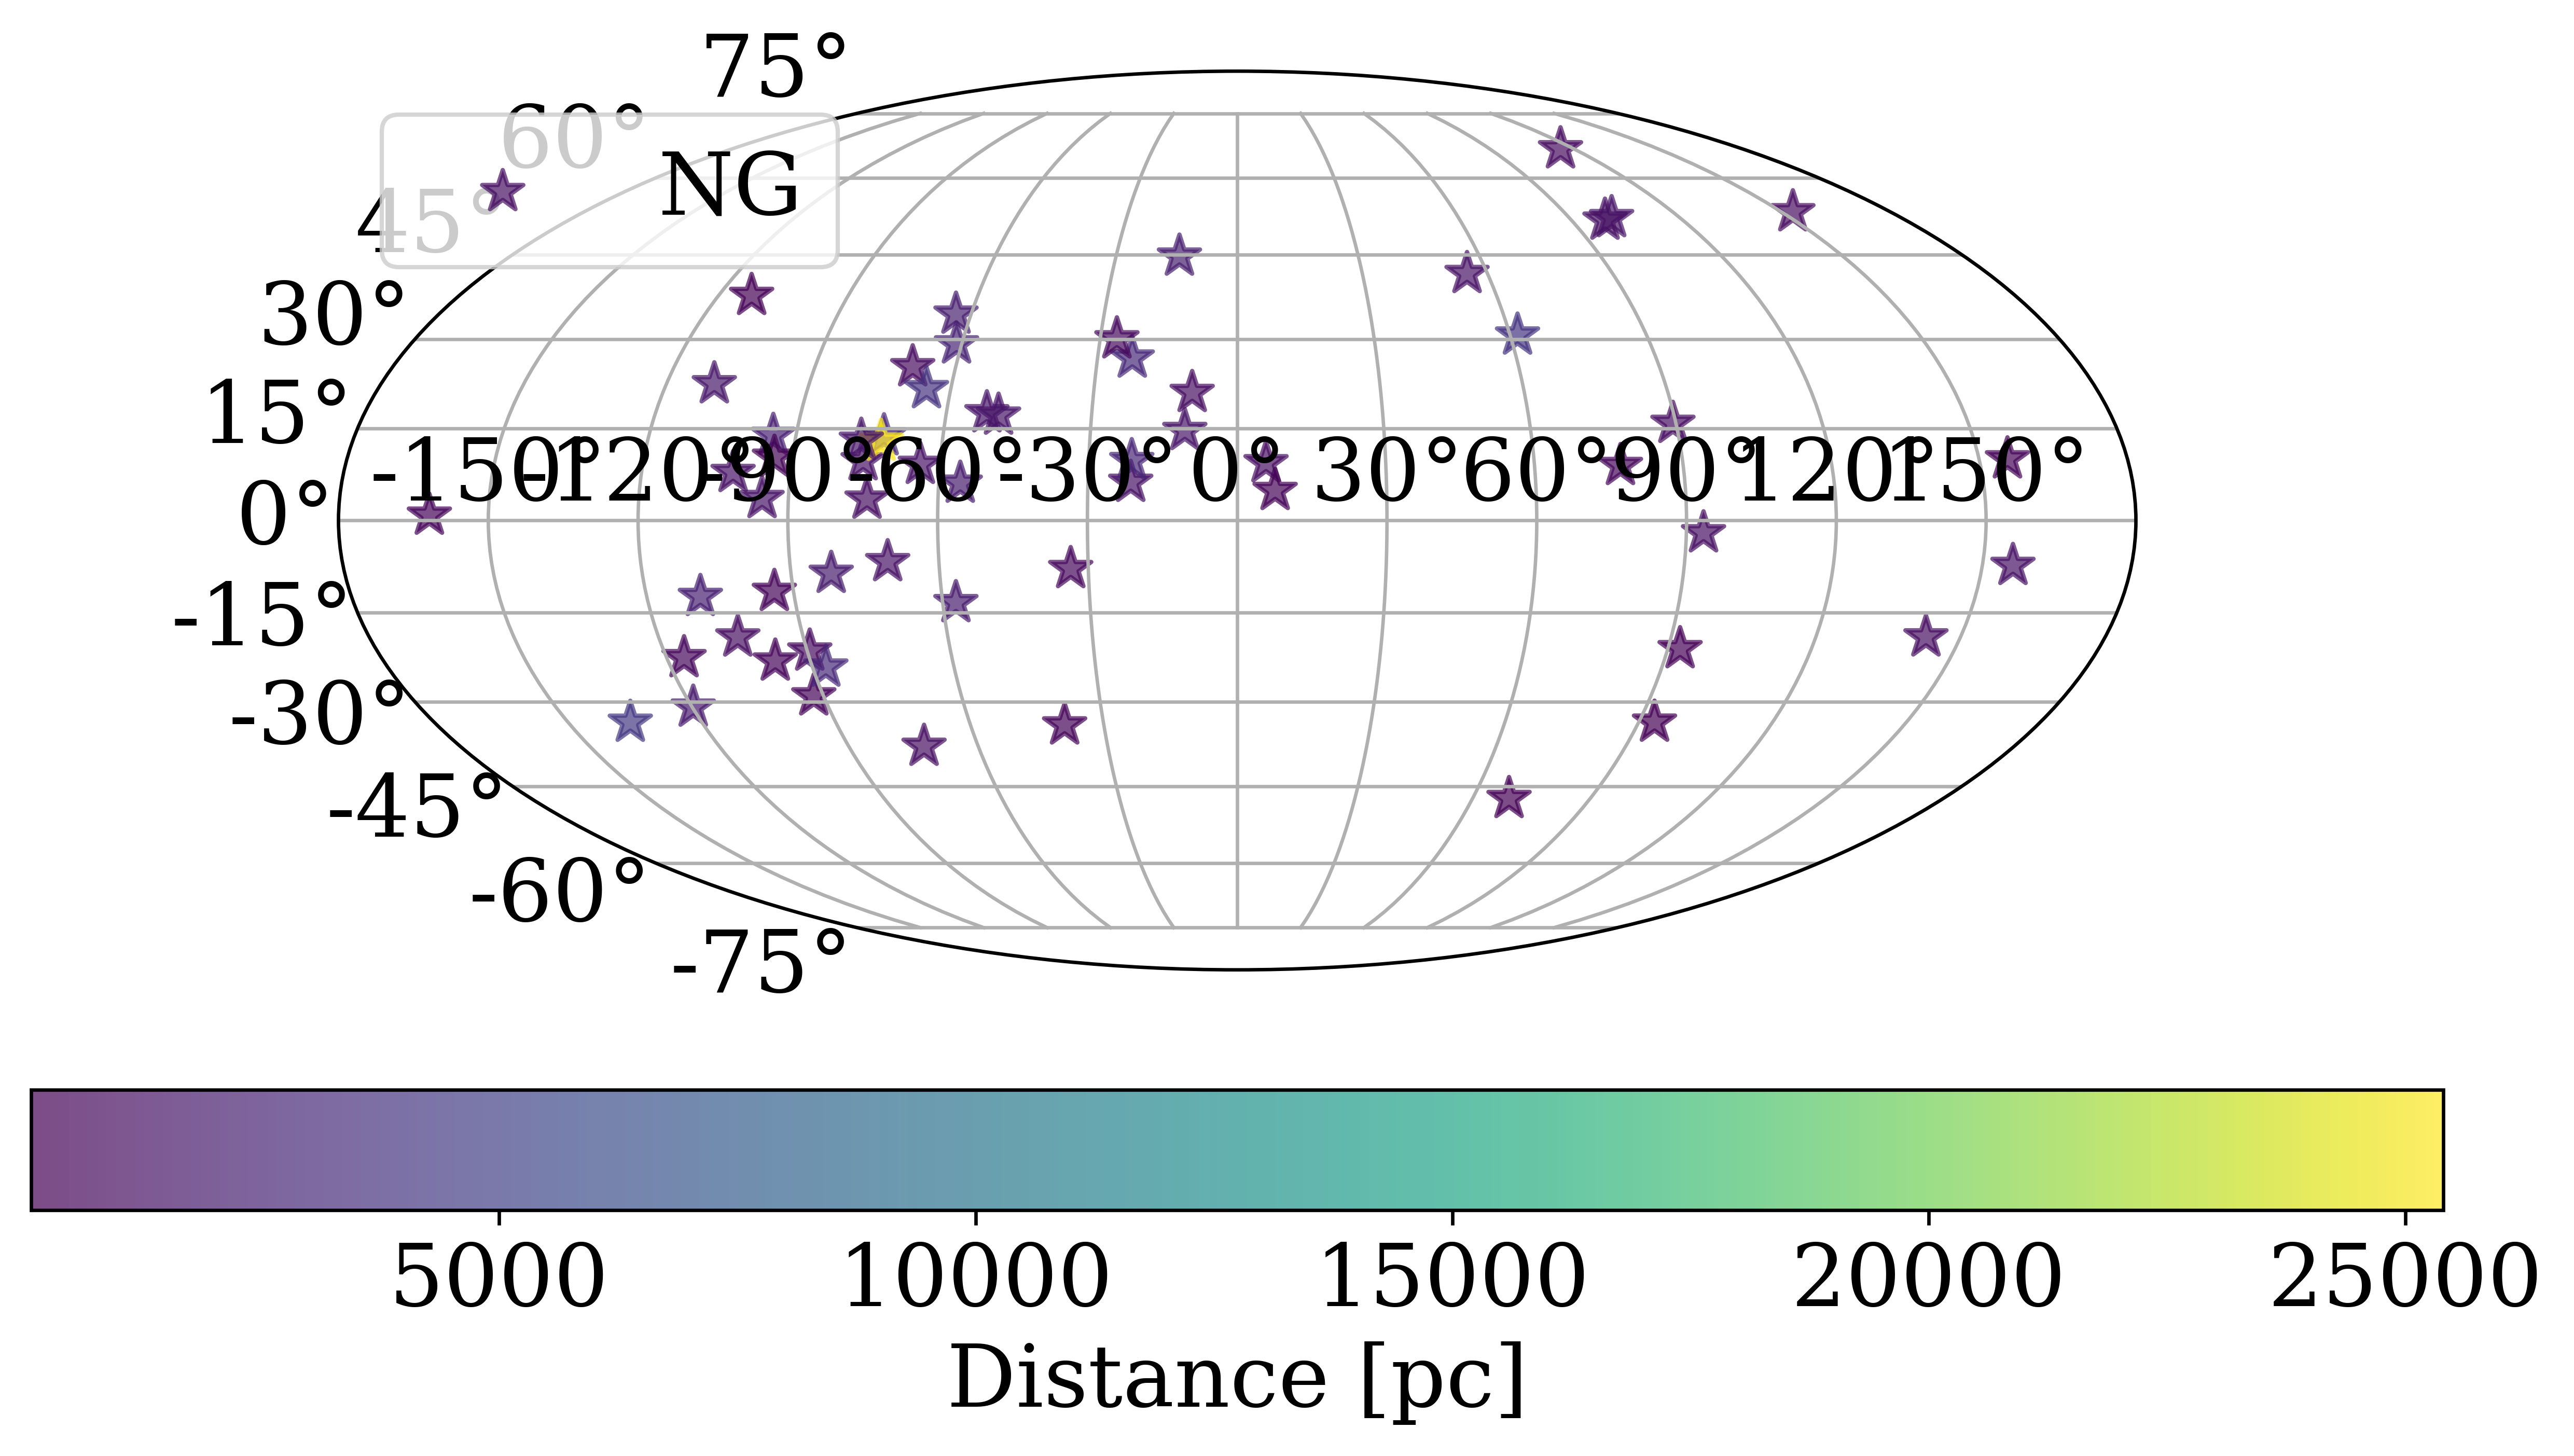

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

f = np.logspace(-9, -7, 100)

_, p_NG, D = detectors.get_NANOGrav_pulsars()
theta_NG = np.arccos(p_NG[:,2])
phi_NG = np.arctan2(p_NG[:,1], p_NG[:,0])

ra_NG = np.degrees(phi_NG)  
dec_NG = 90 - np.degrees(theta_NG)  

ra_NG = np.radians(ra_NG)
dec_NG = np.radians(dec_NG)

#from m to parsec
D = D / 3.086e16

norm = colors.LogNorm(vmin=np.min(D), vmax=np.max(D))
cmap = cm.viridis 

plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='mollweide')
plt.grid(True)


sc = ax.scatter(ra_NG, dec_NG, s=100, c=D, cmap=cmap, alpha=0.7, marker='*')


cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Distance [pc]')

plt.legend(['NG'])
plt.show()


#  The GWB energy density sensitivity spectrum :
## Power law integrated sensitivity curve


## Detectors

sens = pls.PLS(det1, det2, f, fref, pol, snr, Tobs, beta_min, beta_max, psi, shift_angle, fI=None, PnI=None, fJ=None, PnJ=None)

Evaluate the sensitivity of a pair of detectors or a network of detectors to a Gravitational Wave Background (GWB) signal.

Parameters:
- det1, det2 : str or list of str
    The names of the detectors or the network of detectors to be considered.
    Supported options are:
    - Predefined detector or detector networks such as 'ET triangular', 'LISA', or custom detectors defined as lists with specific parameters.
    - For custom detectors, provide a list with the following elements: [c, xA, xB, l, name]
        - c: array_like of length 3 (position of the detector in the Earth-centered frame in meters)
        - xA: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - xB: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - l: float (length of the detector arm in meters)
        - name: str (name of the detector)

- f : array_like
    Frequency values (in Hz) for the Gravitational Wave signal.
- fref : float
    Reference frequency (in Hz) for the signal analysis.
- pol : str
    Polarization of the signal. Should be one of:
    - 't' for tensor polarization
    - 'v' for vector polarization
    - 's' for scalar polarization
    - 'I' for intensity
    - 'V' for circular polarization
- snr : float
    Signal-to-noise ratio (SNR) threshold for the analysis.
- Tobs : float
    Total observation time in years.
- psi : float
    
Optional parameters:

- shift_angle : float, optional
    Shift the angle of the response if considering ET 2L in radians
- fI, PnI, fJ, PnJ : optional
    Frequency arrays and corresponding Power Spectral Densities (PSDs) for custom detectors or custom PSD.
    These are used when no predefined detector networks are chosen.

Returns:
- pls: power law sensitivity curve  (h^2 \Omega_{GW}(f))
    The sensitivity of the detector(s) to the GWB signal, evaluated as the Power-Law Sensitivity (PLS). 
    This is a function of the observation time, SNR, and the detectors' noise characteristics.

Description:
This function calculates the sensitivity of a pair of detectors or a network of detectors to a Gravitational Wave Background (GWB) signal, 
based on the given parameters. 
It evaluates the effective noise power spectral density and energy density for the signal and computes the corresponding sensitivity. 
The analysis can handle both predefined detector networks (such as LISA or ET) and custom detectors with user-supplied parameters.

- For custom detectors, the function interpolates the supplied PSDs with the frequencies given and calculates the overlap response between the detectors.
- The result is the sensitivity of the system to the GWB signal, given in terms of the Power-Law Sensitivity (PLS),
    which quantifies the detector network's ability to detect gravitational waves with the specified polarization, 
    frequency range, and observation time.


## Pulsars


Compute the power law sensitivity curve for a pulsars catalog

If you want to consider EPTA:

pls_NANOGrav = pls.PLS_PTA_EPTA(f_PTA, snr, Tobs_PTA, pol, psi)

If you want to consider NANOGrav:

pls_NANOGrav = pls.PLS_PTA_NANOGrav(f_PTA, snr, Tobs_PTA, pol, psi)



Parameters:
- f: array (frequency array)
- snr: float (signal to noise ratio threshold)
- Tobs: float (observation time in years)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity, 'V' for circular)
- psi: float (Polarization angle in radians)

Returns:
- pls: array [shape: len(f)] (power law sensitivity curve  (h^2 \Omega_{GW}(f))) 



2025-03-12 11:49:22.925 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


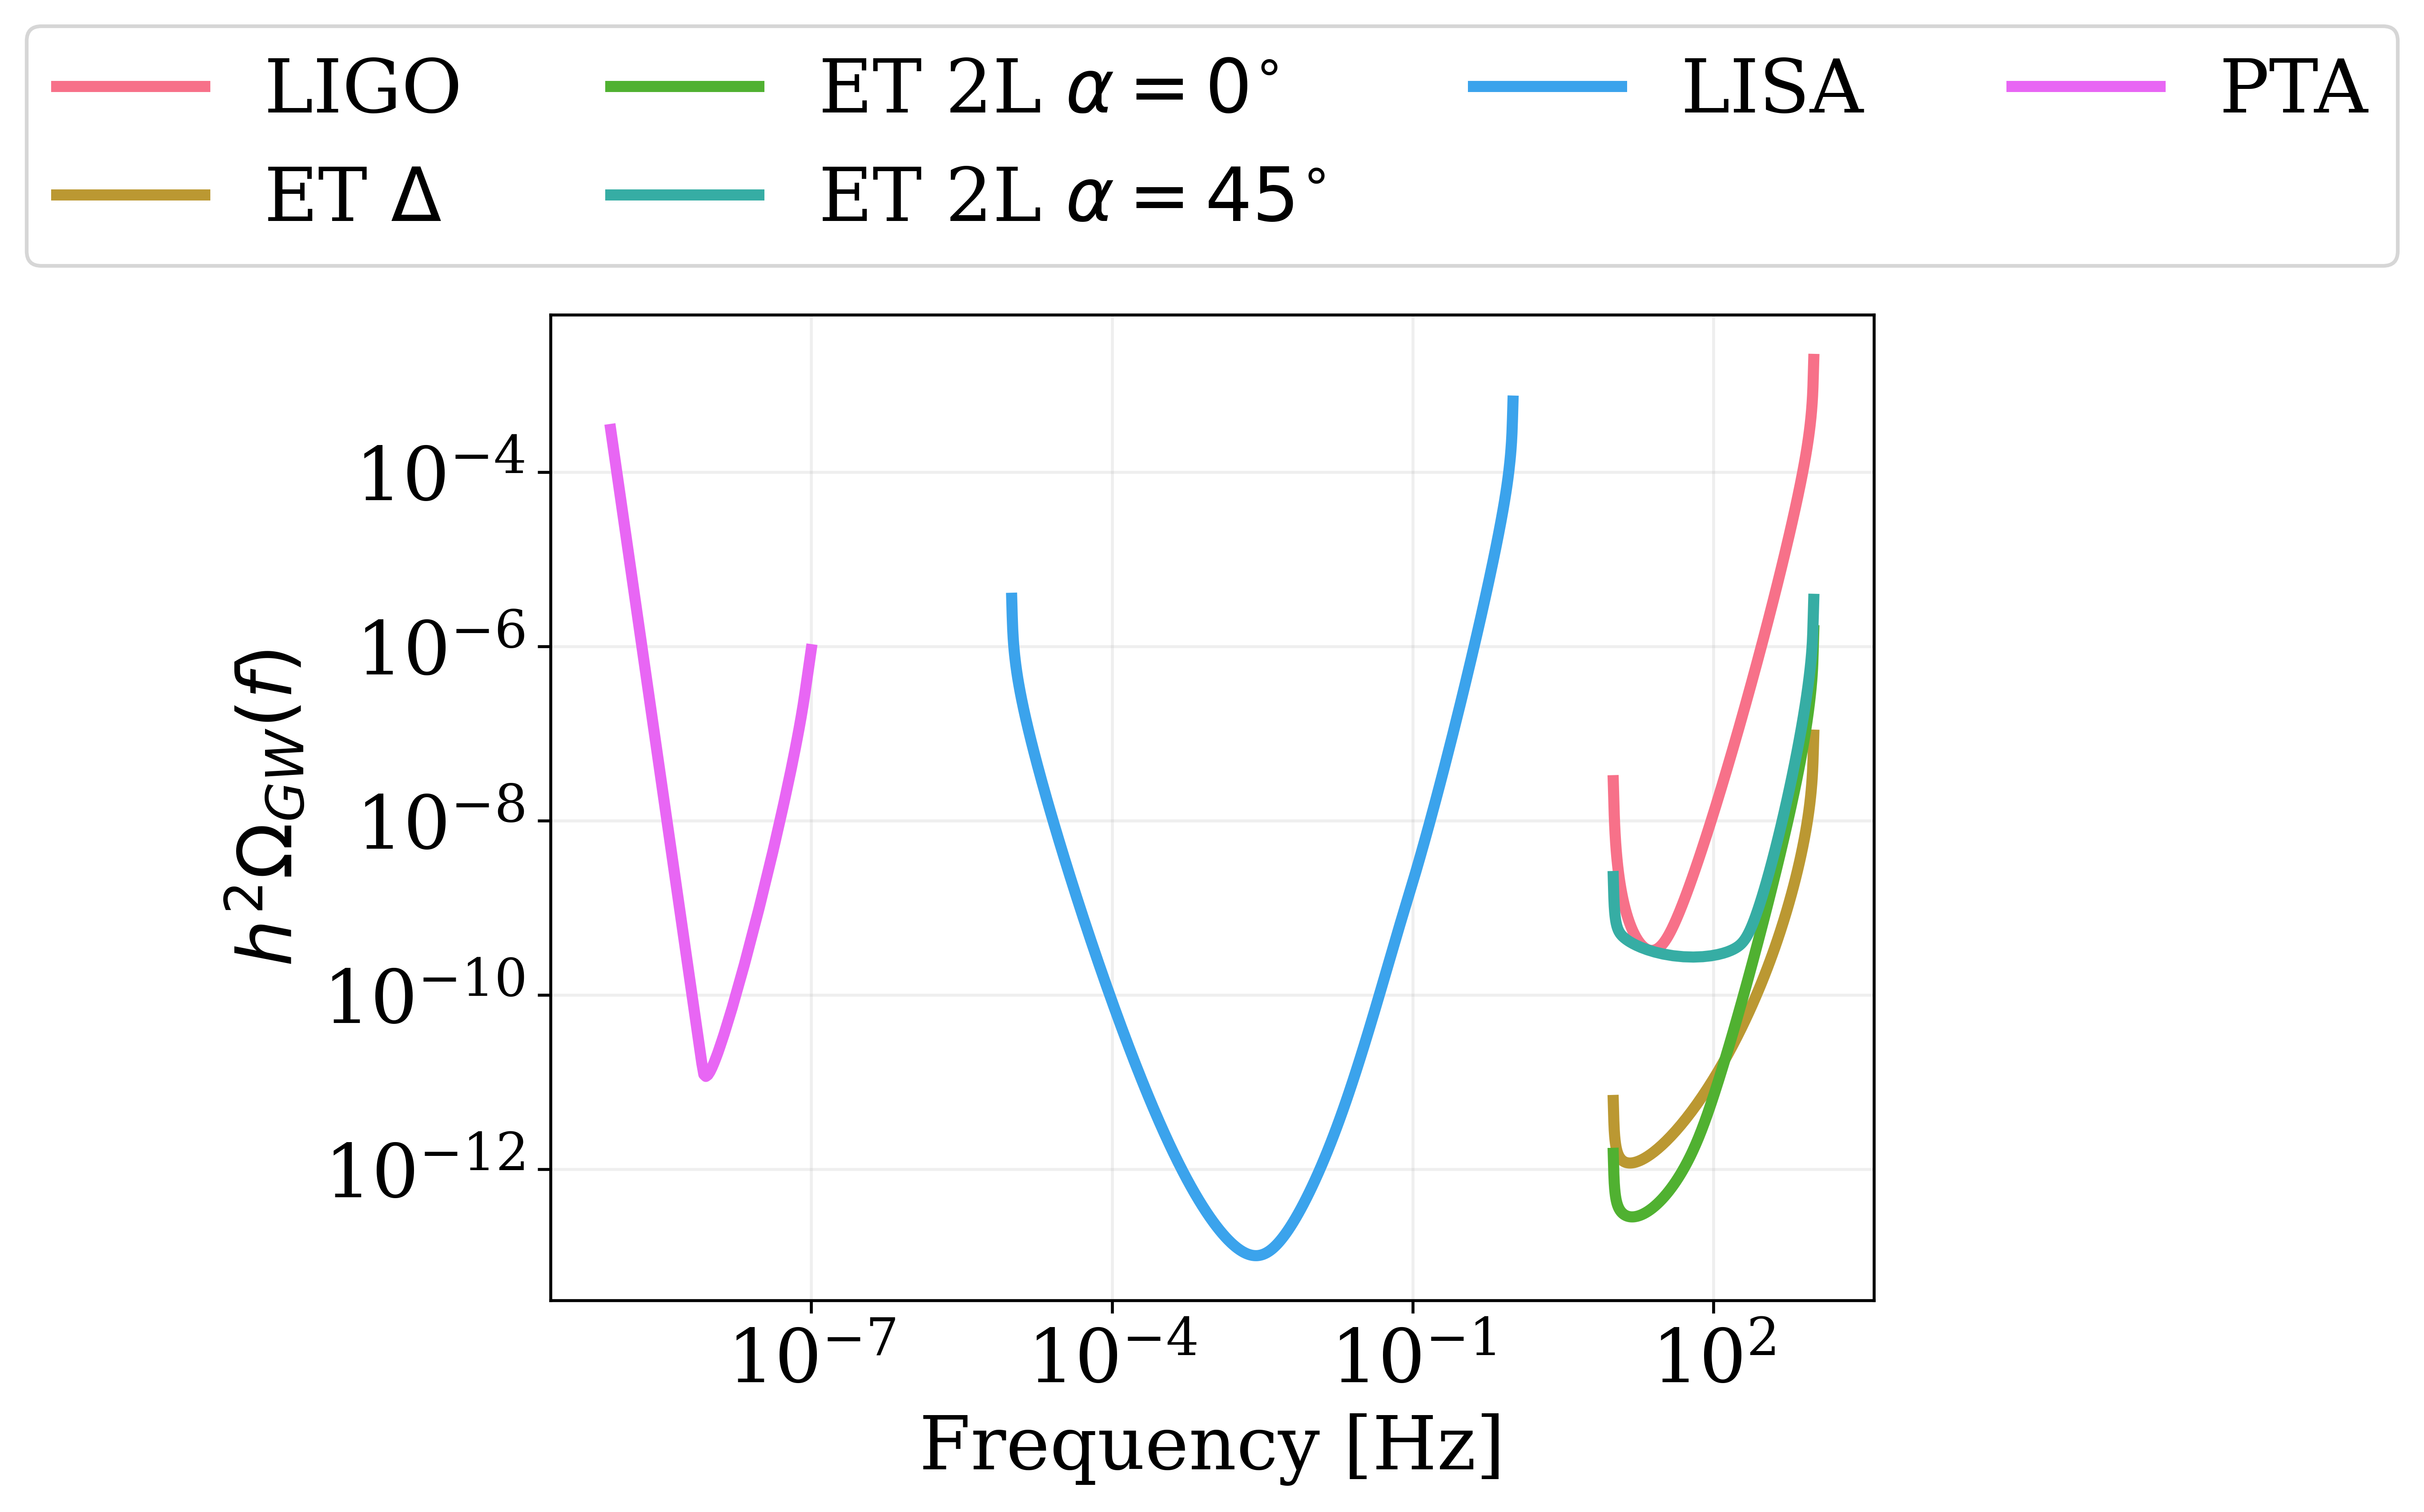

In [85]:
f = np.logspace(1, 3, 1000)
f_LISA = np.logspace(-5, 0, 1000)
f_PTA = np.logspace(-9, -7, 100)

fref = 25
fref_LISA = 1e-2
snr = 1
snr_LISA = 10
Tobs = 1
Tobs_LISA = 3
psi = 0
Tobs_PTA = 15

pls_LIGO = pls.PLS('LIGO H', 'LIGO L', f, fref, 't', snr, Tobs, psi)
pls_ET = pls.PLS('ET X', 'ET Y', f, fref, 't', snr, Tobs, psi)
pls_ET2L0 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr, Tobs, psi, 0)
pls_ET2L45 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr, Tobs, psi, np.pi/4)
pls_LISA = pls.PLS('LISA', 'Network', f_LISA, fref_LISA, 't', snr_LISA, Tobs_LISA, psi)
pls_PTA = pls.PLS_PTA(f_PTA, snr, Tobs_PTA, 't', psi)

plt.plot(f, pls_LIGO, label='LIGO')
plt.plot(f, pls_ET, label=r'ET $\Delta$')
plt.plot(f, pls_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, pls_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$')
plt.plot(f_LISA, pls_LISA, label='LISA')
plt.plot(f_PTA, pls_PTA, label='PTA')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33), ncol=4)
plt.grid(which='both', alpha=0.2)
plt.show()

2025-03-12 15:57:09.241 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 15:57:21.092 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 15:57:33.028 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


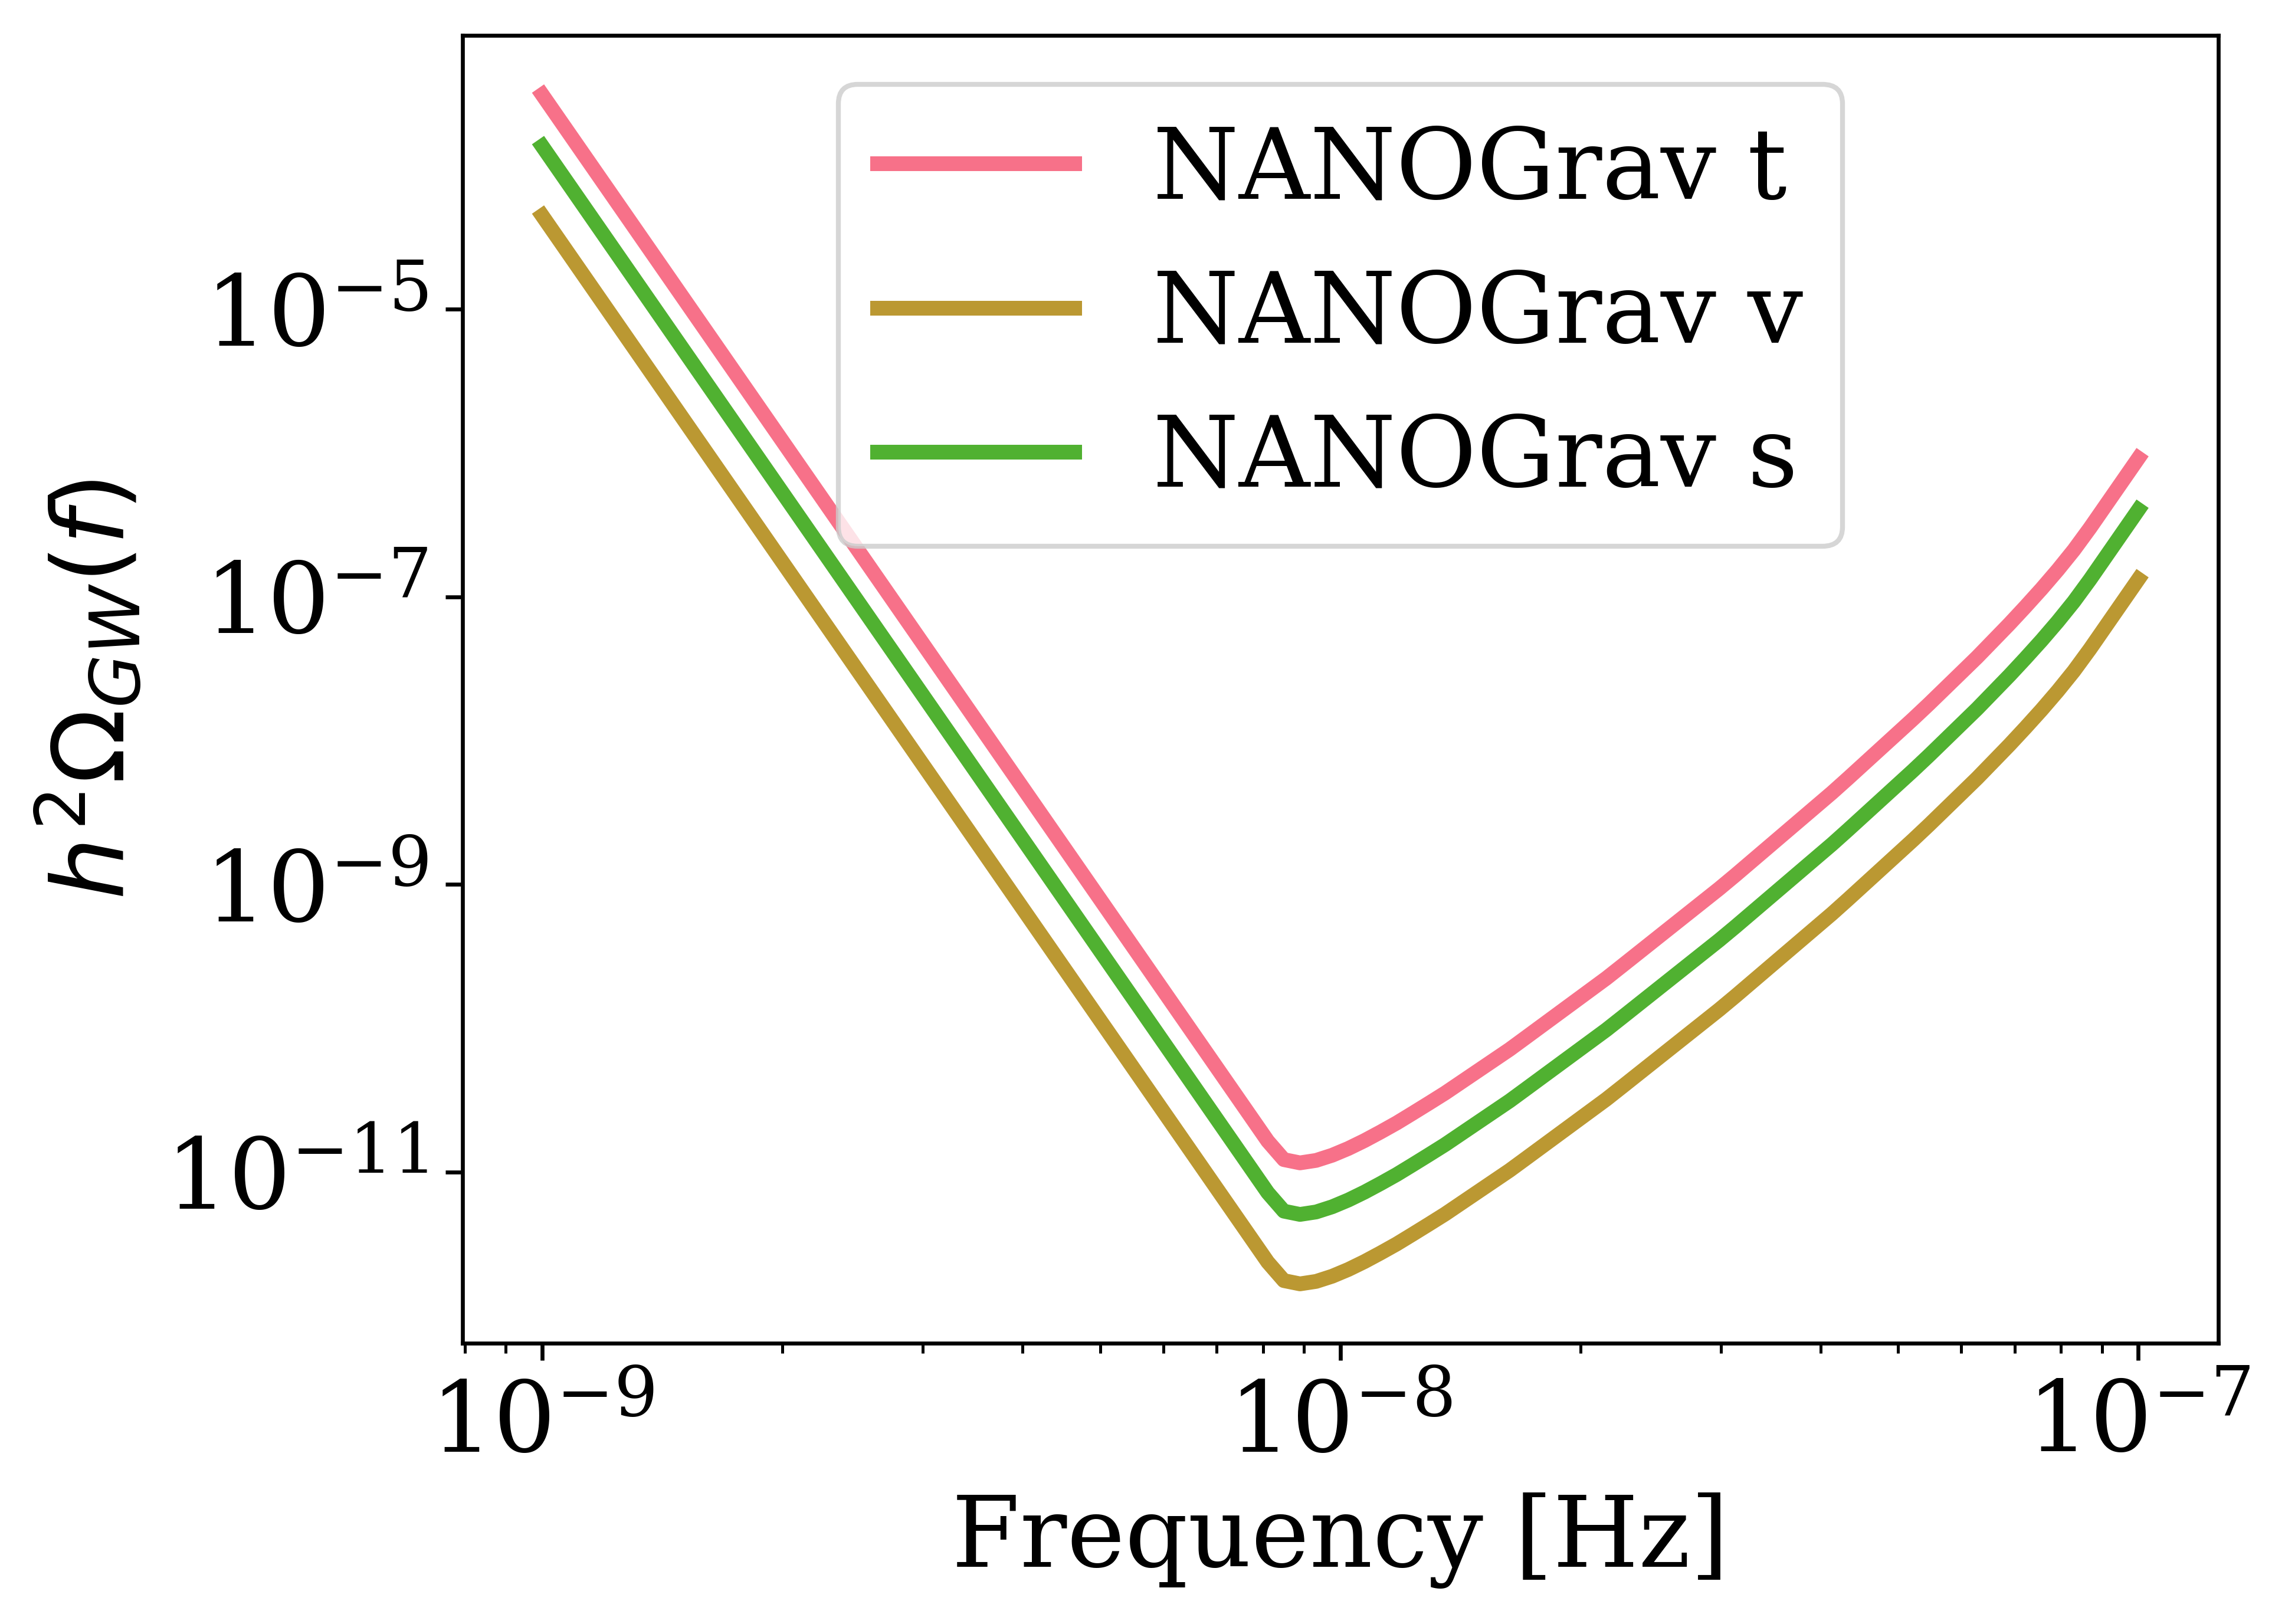

In [15]:
psi = 0
Tobs_PTA = 15
snr = 1

f_PTA = np.logspace(-9, -7, 100)
pls_NANOGrav_t = pls.PLS_PTA(f_PTA, snr, Tobs_PTA, 't', psi)
pls_NANOGrav_v = pls.PLS_PTA(f_PTA, snr, Tobs_PTA, 'v', psi)
pls_NANOGrav_s = pls.PLS_PTA(f_PTA, snr, Tobs_PTA, 's', psi)

plt.plot(f_PTA, pls_NANOGrav_t, label='NANOGrav t')
plt.plot(f_PTA, pls_NANOGrav_v, label='NANOGrav v')
plt.plot(f_PTA, pls_NANOGrav_s, label='NANOGrav s')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [16]:
print(np.min(pls_NANOGrav_t))
print(np.min(pls_NANOGrav_v))
print(np.min(pls_NANOGrav_s))

# 1.1618659106304505e-11
# 1.6760036321347296e-12
# 5.092882264989845e-12


1.1618659106304505e-11
1.6760036321347296e-12
5.092882264989845e-12


In [66]:
from gwbird import snr

h=0.7

Tobs_PTA = 15

f_PTA = np.logspace(-9, -7, 100)

snr_NANOGrav = snr.SNR(Tobs_PTA, f_PTA, np.log10(1.1618659106304498e-11/h**2), 0, 1e-8, ['pulsars'], 't', psi=0)
print(snr_NANOGrav)

import beepy
beepy.beep(sound=1) 

# Tobs = 1
# f = np.logspace(1, 3, 1000)
# logA_gw = np.log10(pls_ET2L45.min()/h**2)
# fref=25
# n_gw = 0
# det_list = ['ET L1', 'ET L2']
# snr_LIGO = snr.SNR(Tobs, f, logA_gw, n_gw, fref, det_list, 't', psi=0, shift_angle=np.pi/4)
# print(snr_LIGO)

# Tobs = 3
# f = np.logspace(-5, 0, 1000)
# logA_gw = np.log10(pls_LISA.min()/h**2)
# fref=1e-2
# n_gw = 0
# snr_LISA = snr.SNR(Tobs, f, logA_gw, n_gw, fref, ['LISA'], 't', psi=0, shift_angle=None)
# print(snr_LISA)


2025-03-11 17:14:23.394 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


1.0002492346132685


# Angular Response

## Detectors

Calculate the angular response of a detector to a GWB signal for a specific multipole ell.

R_ell = AngularResponse.R_ell( ell, det1, det2, f, pol, psi, shift_angle=False)

Parameters:
- ell: int positive (Multipole to consider)
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity and 'V' for circular polarization)
- psi: float (Polarization angle in radians)

Optional parameters:

- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)


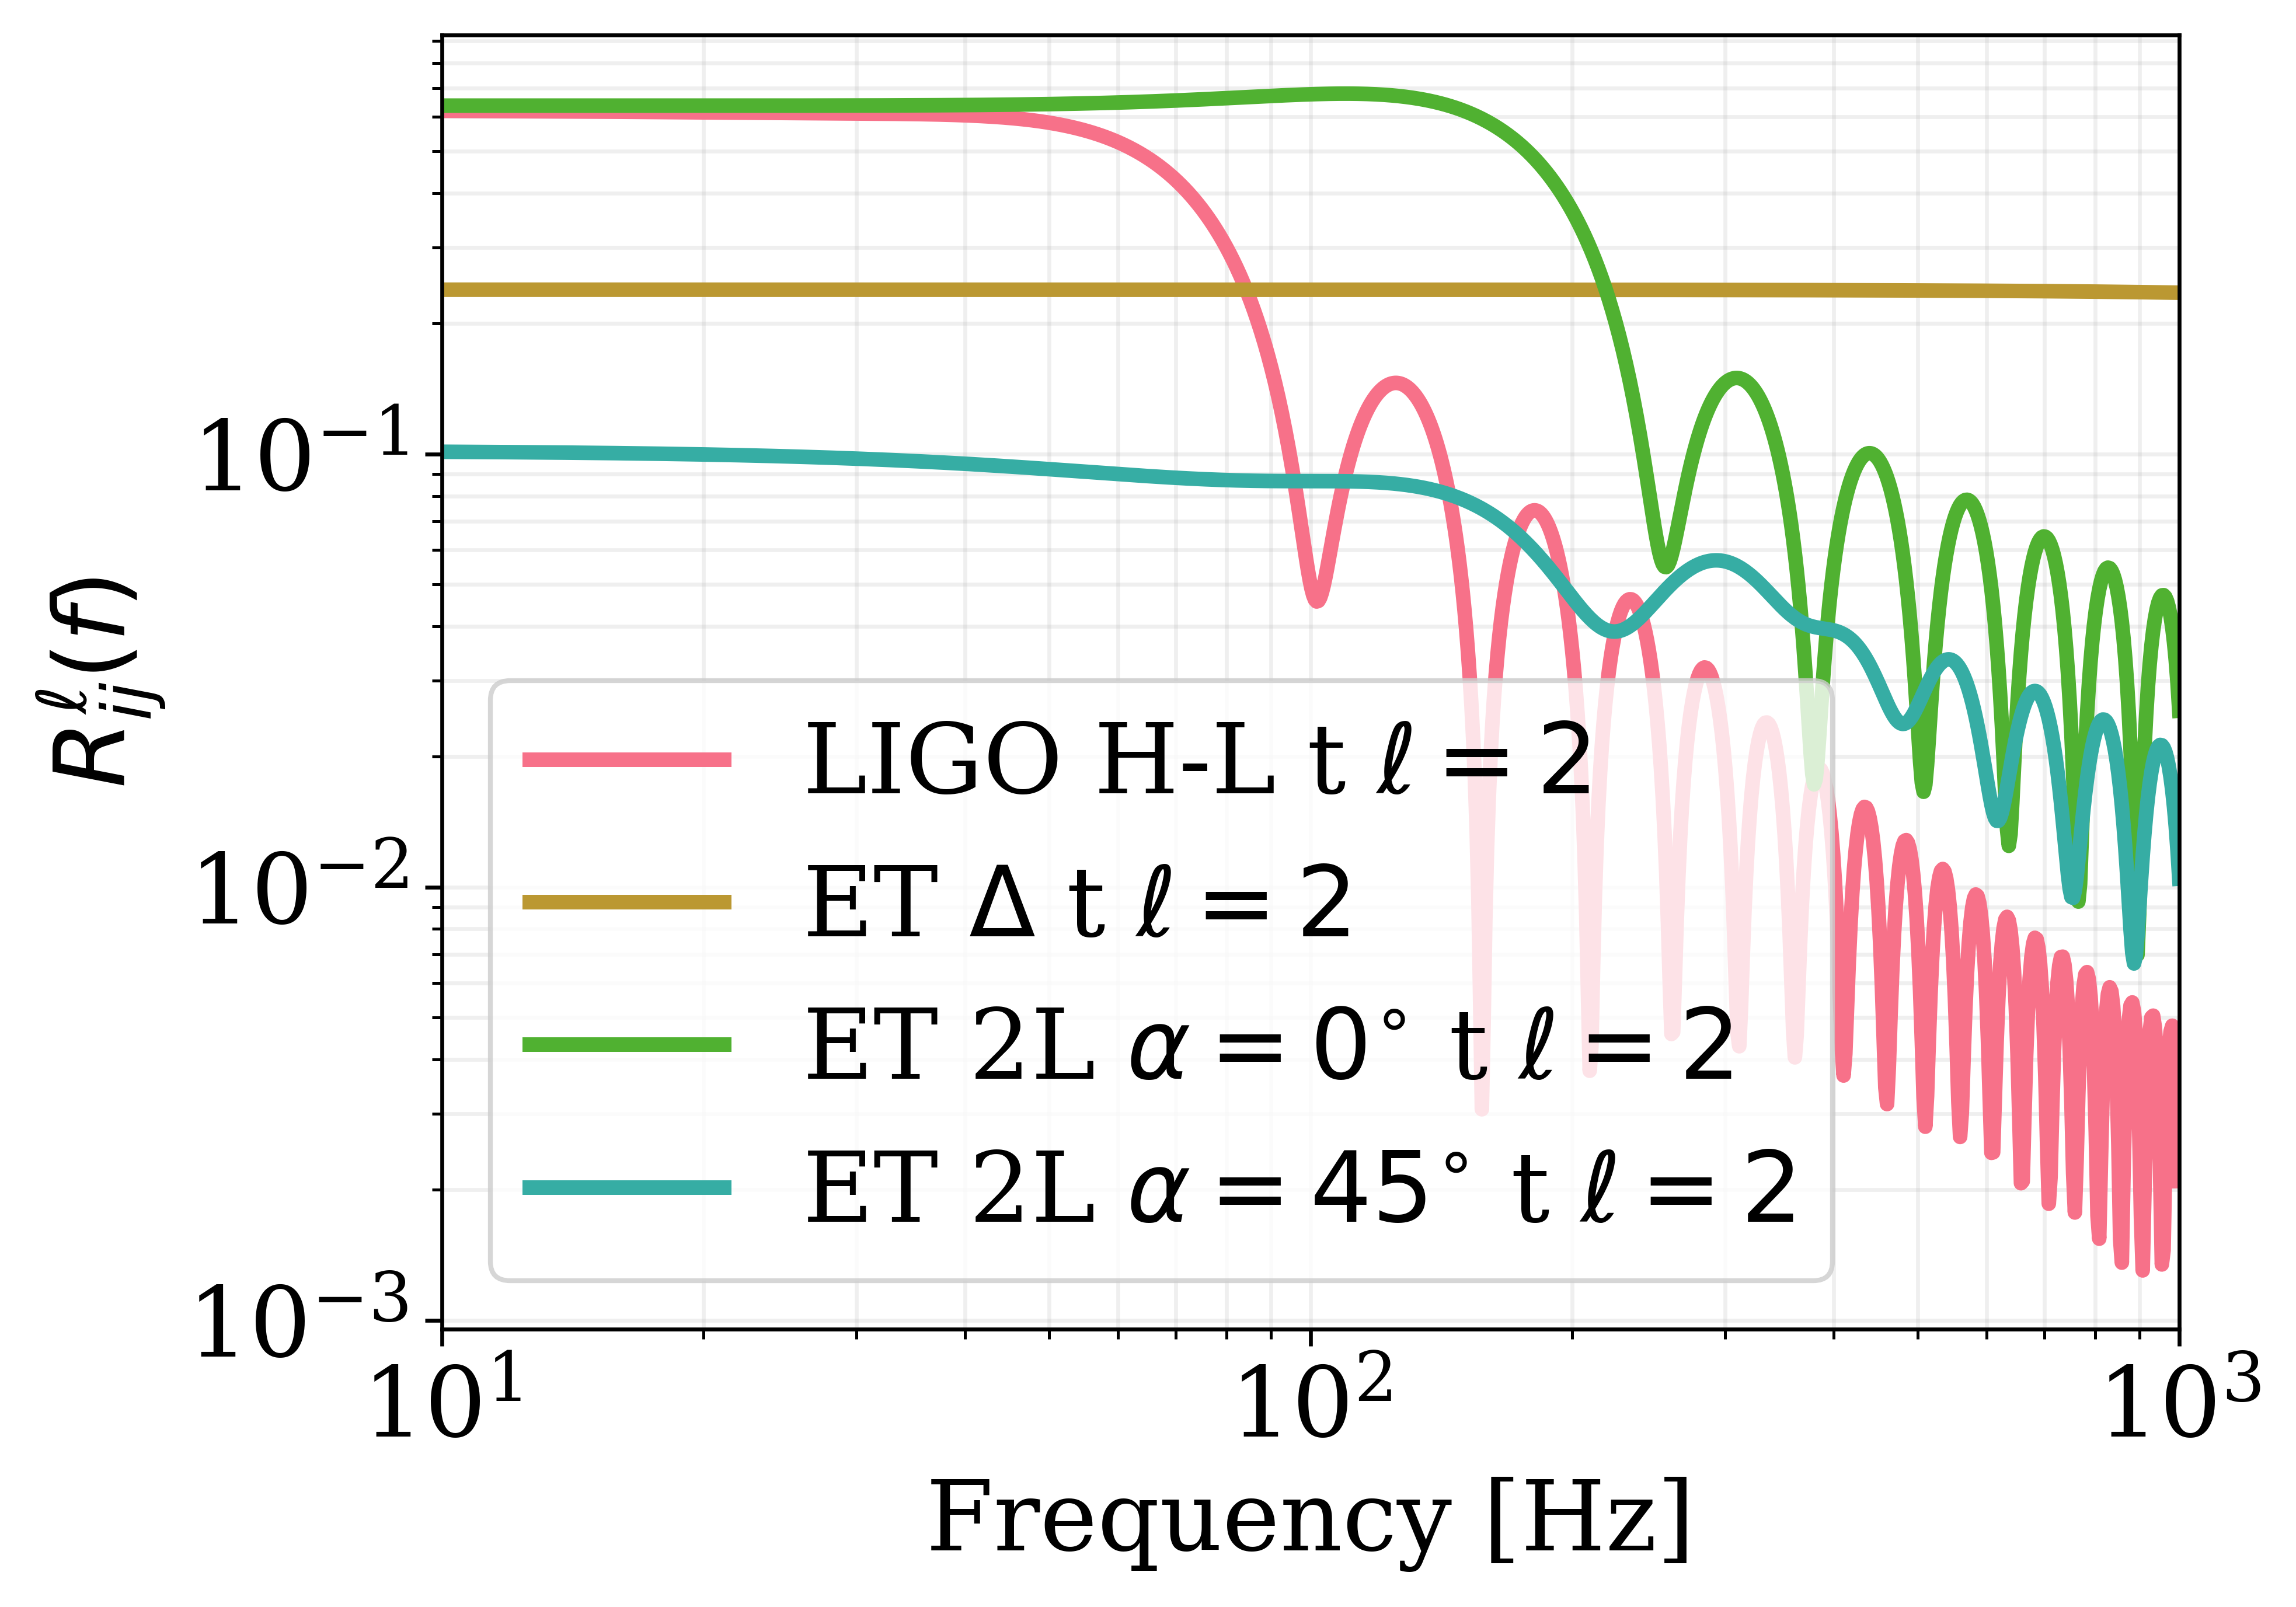

In [91]:
ell = 2
R2_LIGO = AngularResponse.R_ell(ell, 'LIGO H', 'LIGO L', f, 't', 0)
R2_ET = AngularResponse.R_ell(ell, 'ET X', 'ET Y', f, 't', 0)
R2_ET2L0 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=0)
R2_ET2L45 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=np.pi/4)

plt.plot(f, R2_LIGO, label=r'LIGO H-L t $\ell=2$')
plt.plot(f, R2_ET, label=r'ET $\Delta$ t $\ell=2$')
plt.plot(f, R2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$')
plt.plot(f, R2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$')

plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()  

## LISA AET basis

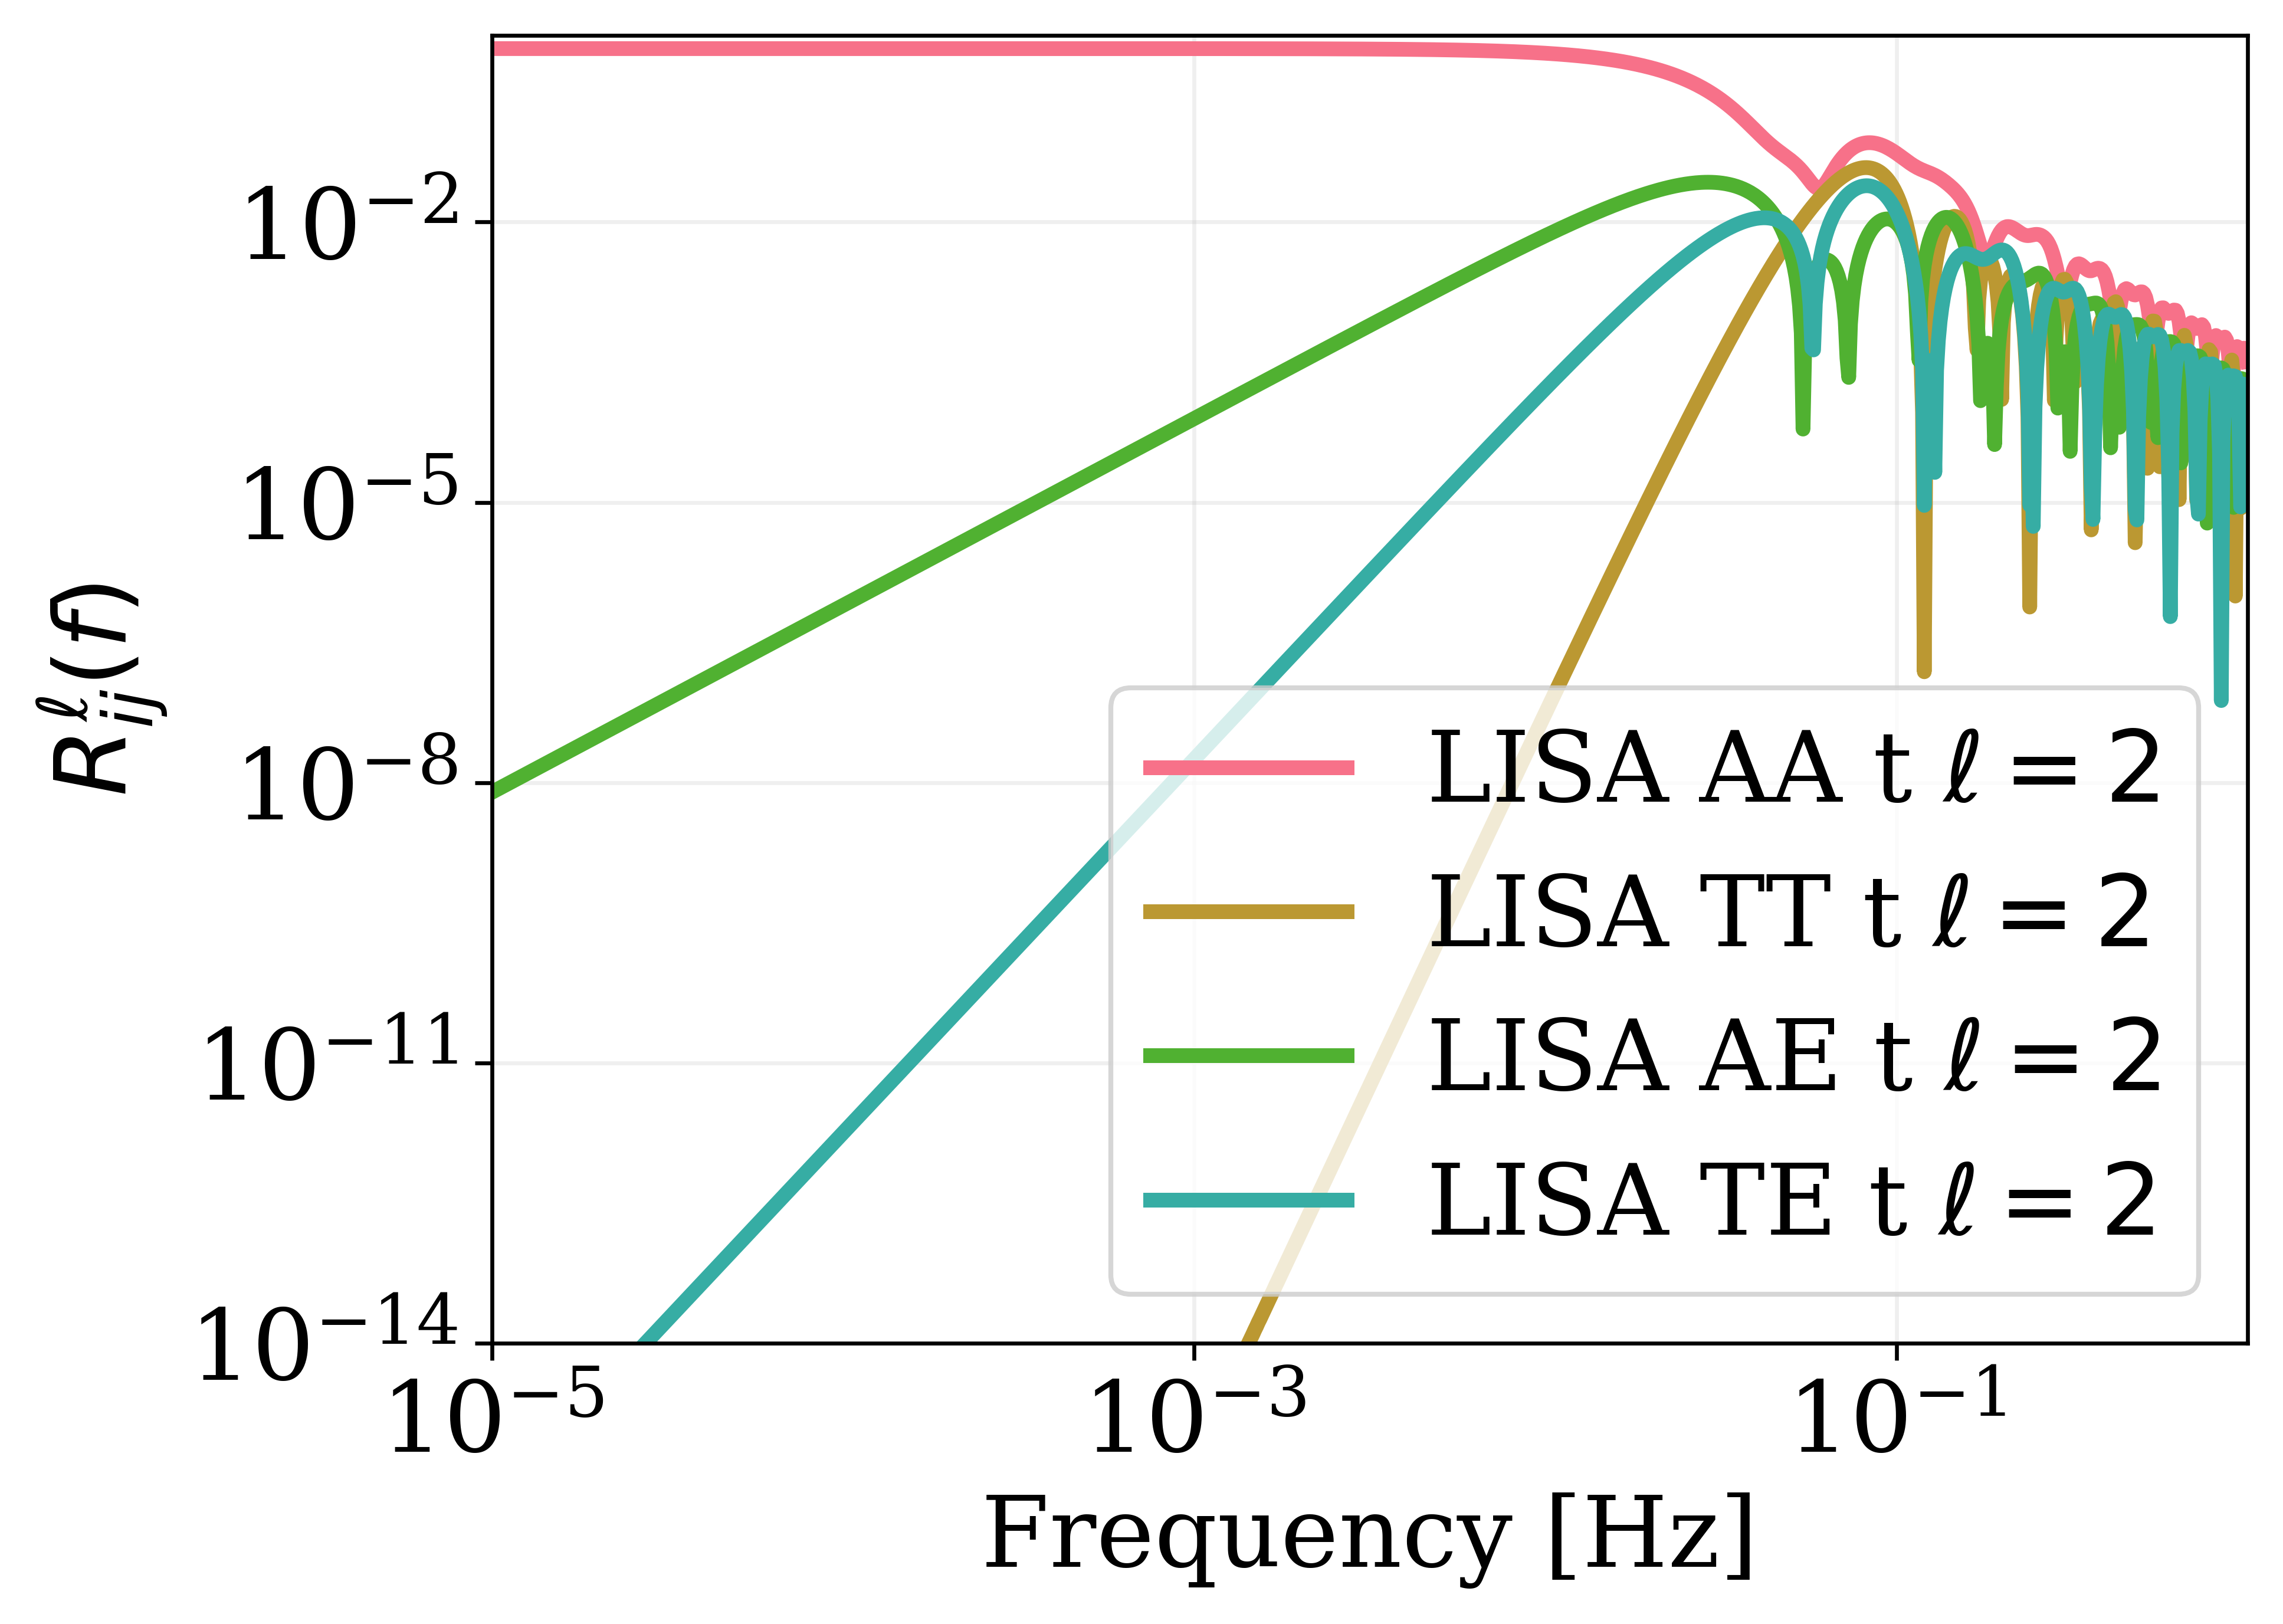

In [44]:
ell = 2
R2_LISA_AA = AngularResponse.R_ell(ell,'LISA A', 'LISA A', f_lisa, 't', 0)
R2_LISA_TT = AngularResponse.R_ell(ell,'LISA T', 'LISA T', f_lisa, 't', 0)
R2_LISA_AE = AngularResponse.R_ell(ell,'LISA A', 'LISA E', f_lisa, 't', 0)
R2_LISA_TE = AngularResponse.R_ell(ell,'LISA E', 'LISA T', f_lisa, 't', 0)


plt.figure()
plt.plot(f_lisa, R2_LISA_AA, label='LISA AA t $\ell=2$')
plt.plot(f_lisa, R2_LISA_TT, label='LISA TT t $\ell=2$')
plt.plot(f_lisa, R2_LISA_AE, label='LISA AE t $\ell=2$')
plt.plot(f_lisa, R2_LISA_TE, label='LISA TE t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.ylim(1e-14, 1)
plt.legend()


# Angular Power Law Sensitivity Curve

## Detectors


Evaluate the sensitivity of a couple of detector to a GWB signal for a specific multipole ell.

sens_ell = Sensitivity_ell.PLS_ell(det1, det2, ell, f, pol, psi, fref, snr, Tobs, Cl, shift_angle=None, fI=None, PnI=None, fJ=None, PnJ=None)


 https://arxiv.org/pdf/2201.08782 eq.4.42 - 4.43

Parameters:
- det1, det2 : str or list of str
    The names of the detectors or the network of detectors to be considered.
    Supported options are:
    - Predefined detector or detector networks such as 'ET triangular', 'LISA', or custom detectors defined as lists with specific parameters.
    - For custom detectors, provide a list with the following elements: [c, xA, xB, l, name]
        - c: array_like of length 3 (position of the detector in the Earth-centered frame in meters)
        - xA: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - xB: array_like of length 3 (unit vector pointing towards the detector in the Earth-centered frame)
        - l: float (length of the detector arm in meters)
        - name: str (name of the detector)

- ell (int): Multipole moment.
- f (array): Frequency array.
- pol (float): Polarization.
- psi (float): Polarization angle.
- fref (float): Reference frequency.
- snr (float): Signal-to-noise ratio threshold.
- Tobs (float): Observation time in years.
- Cl (float): Cl parameter for multipole.
- shift_angle (float, optional): Shift angle.
- fI, PnI, fJ, PnJ (array, optional): Frequency and noise power spectral density for custom detectors.

Returns:
- pls (array_like): power law sensitivity curve  (h^2 \Omega_{GW}(f))


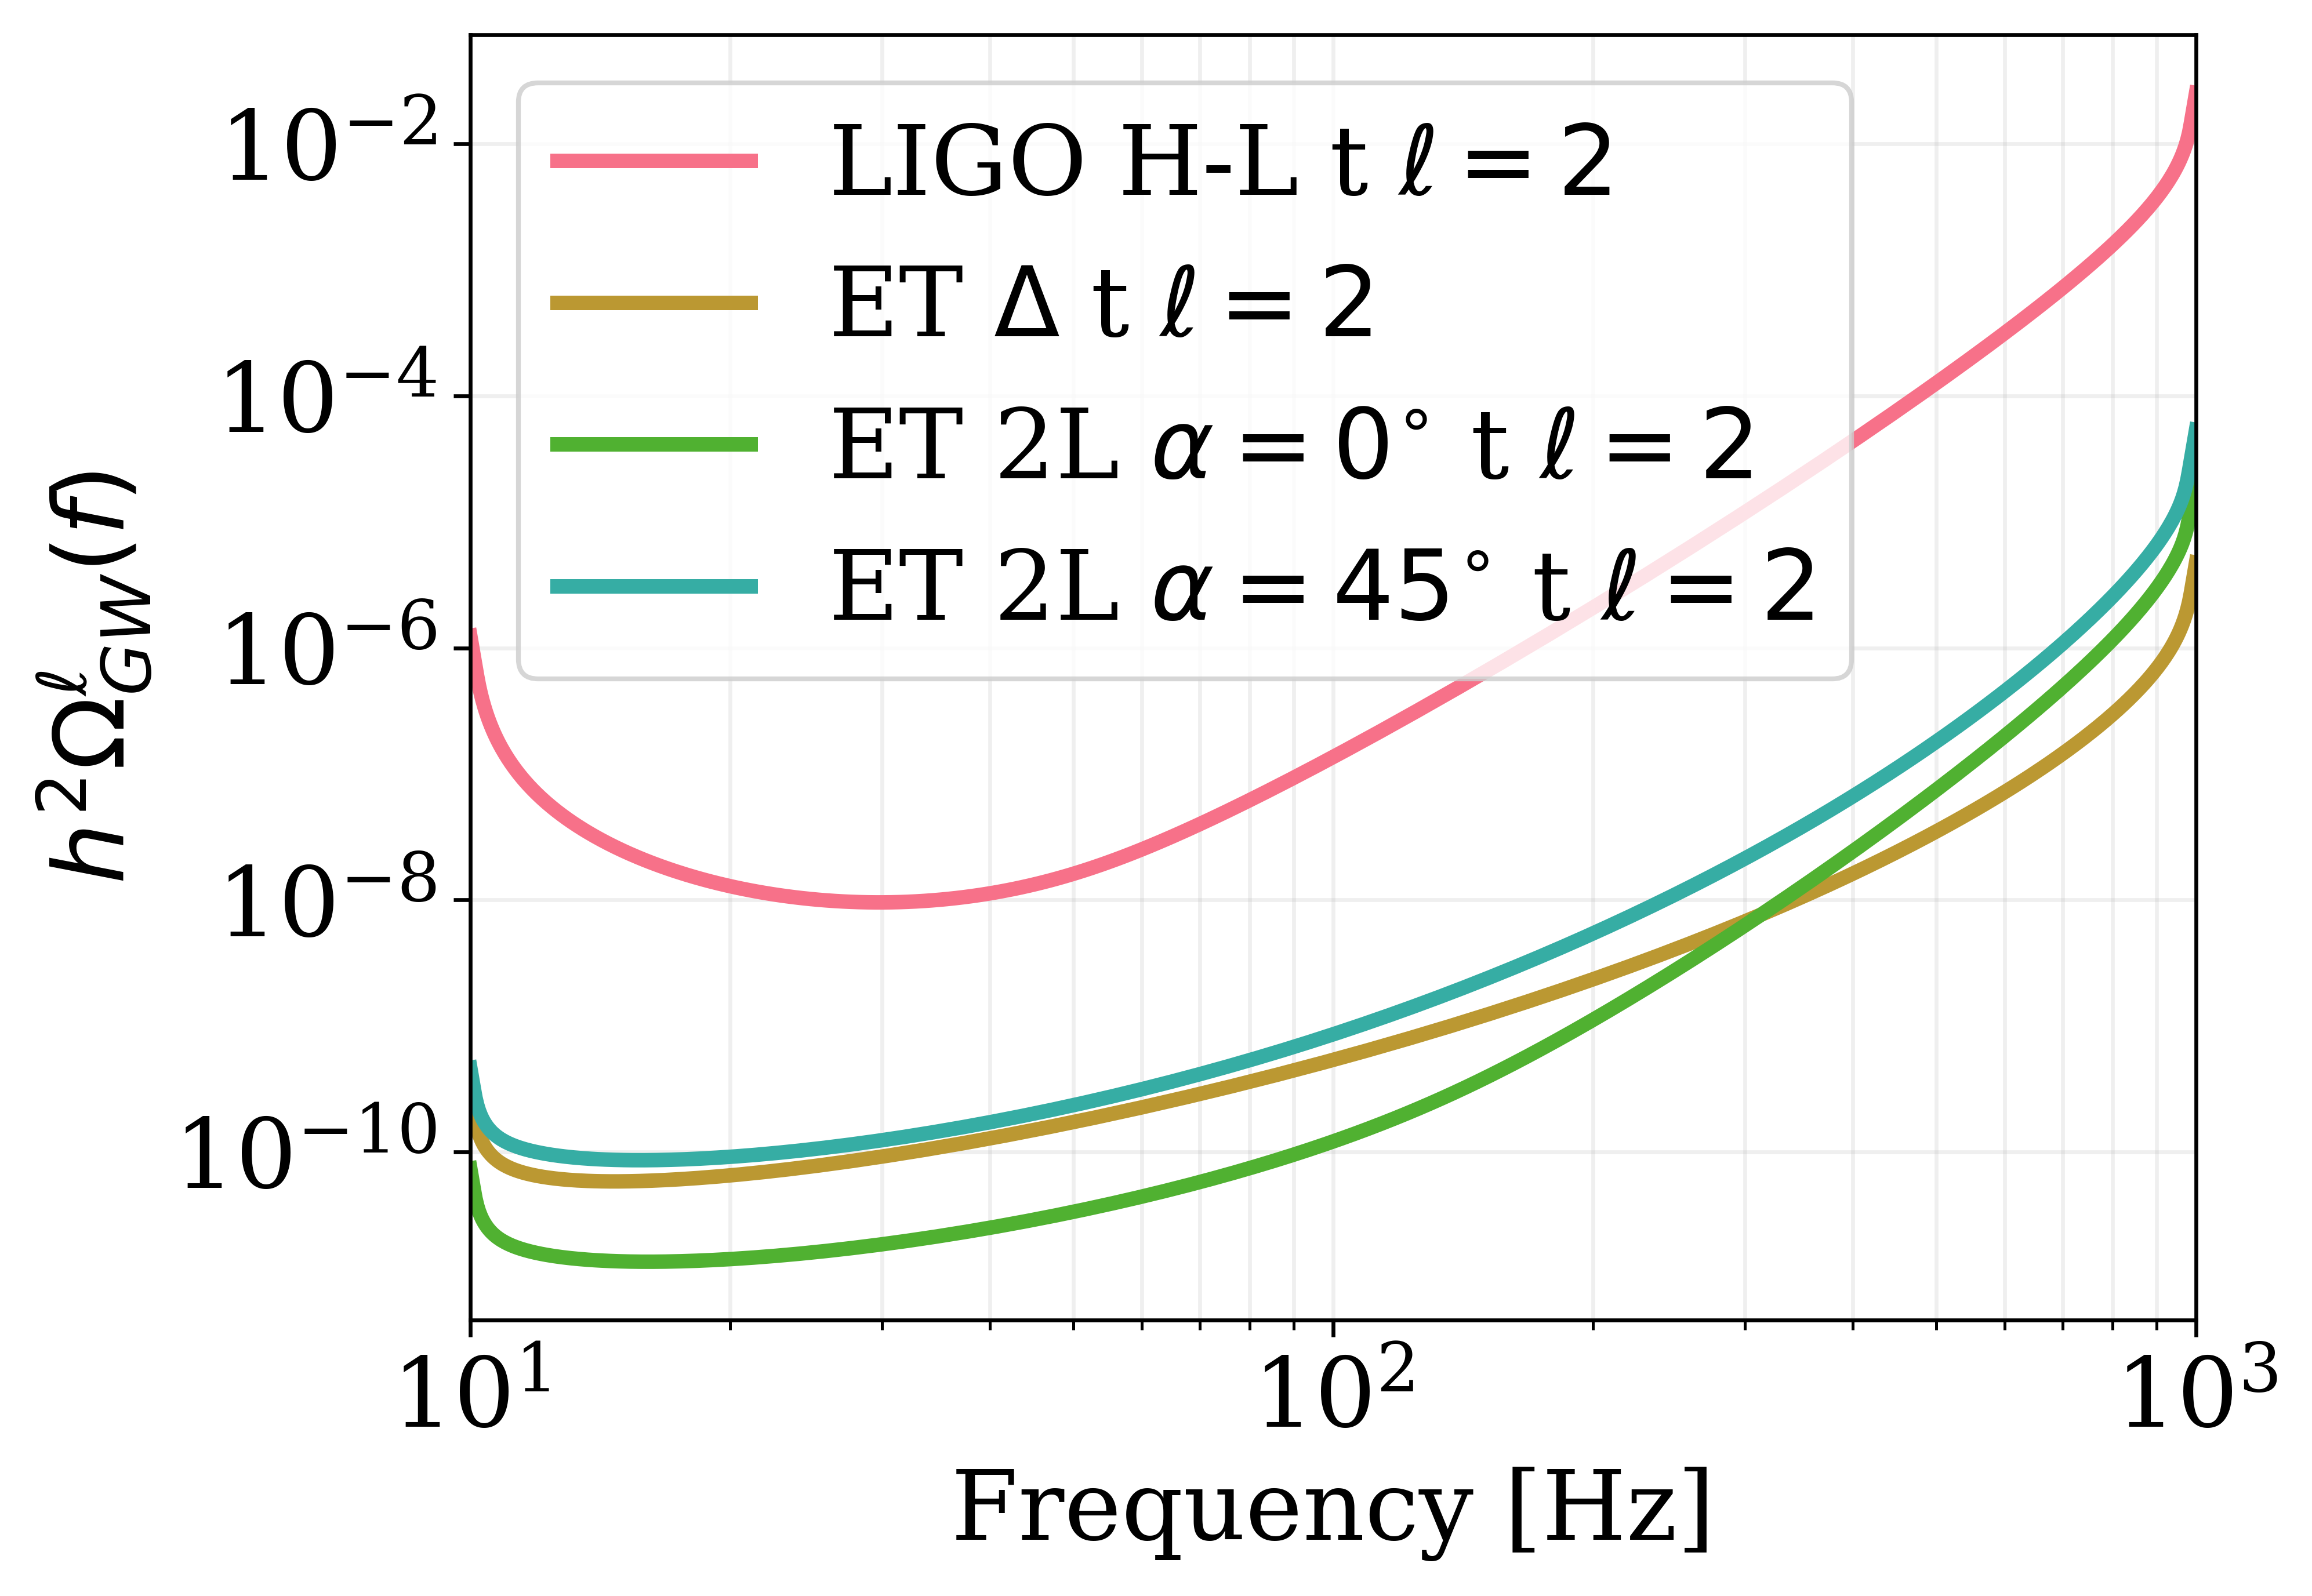

In [92]:
Cl = 1e-3
l=2
Tobs = 1
fref = 10
snr = 1

pls2_LIGO = Sensitivity_ell.PLS_ell('LIGO H', 'LIGO L', l, f, 't', 0, fref, snr, Tobs, Cl)
pls2_ET = Sensitivity_ell.PLS_ell('ET X', 'ET Y', l, f, 't', 0, fref,  snr, Tobs,  Cl)
pls2_ET2L0 = Sensitivity_ell.PLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs, Cl, 0)
pls2_ET2L45 = Sensitivity_ell.PLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs,  Cl, np.pi/4)

plt.plot(f, pls2_LIGO, label=r'LIGO H-L t $\ell=2$')
plt.plot(f, pls2_ET, label=r'ET $\Delta$ t $\ell=2$')
plt.plot(f, pls2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$')
plt.plot(f, pls2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()


## LISA

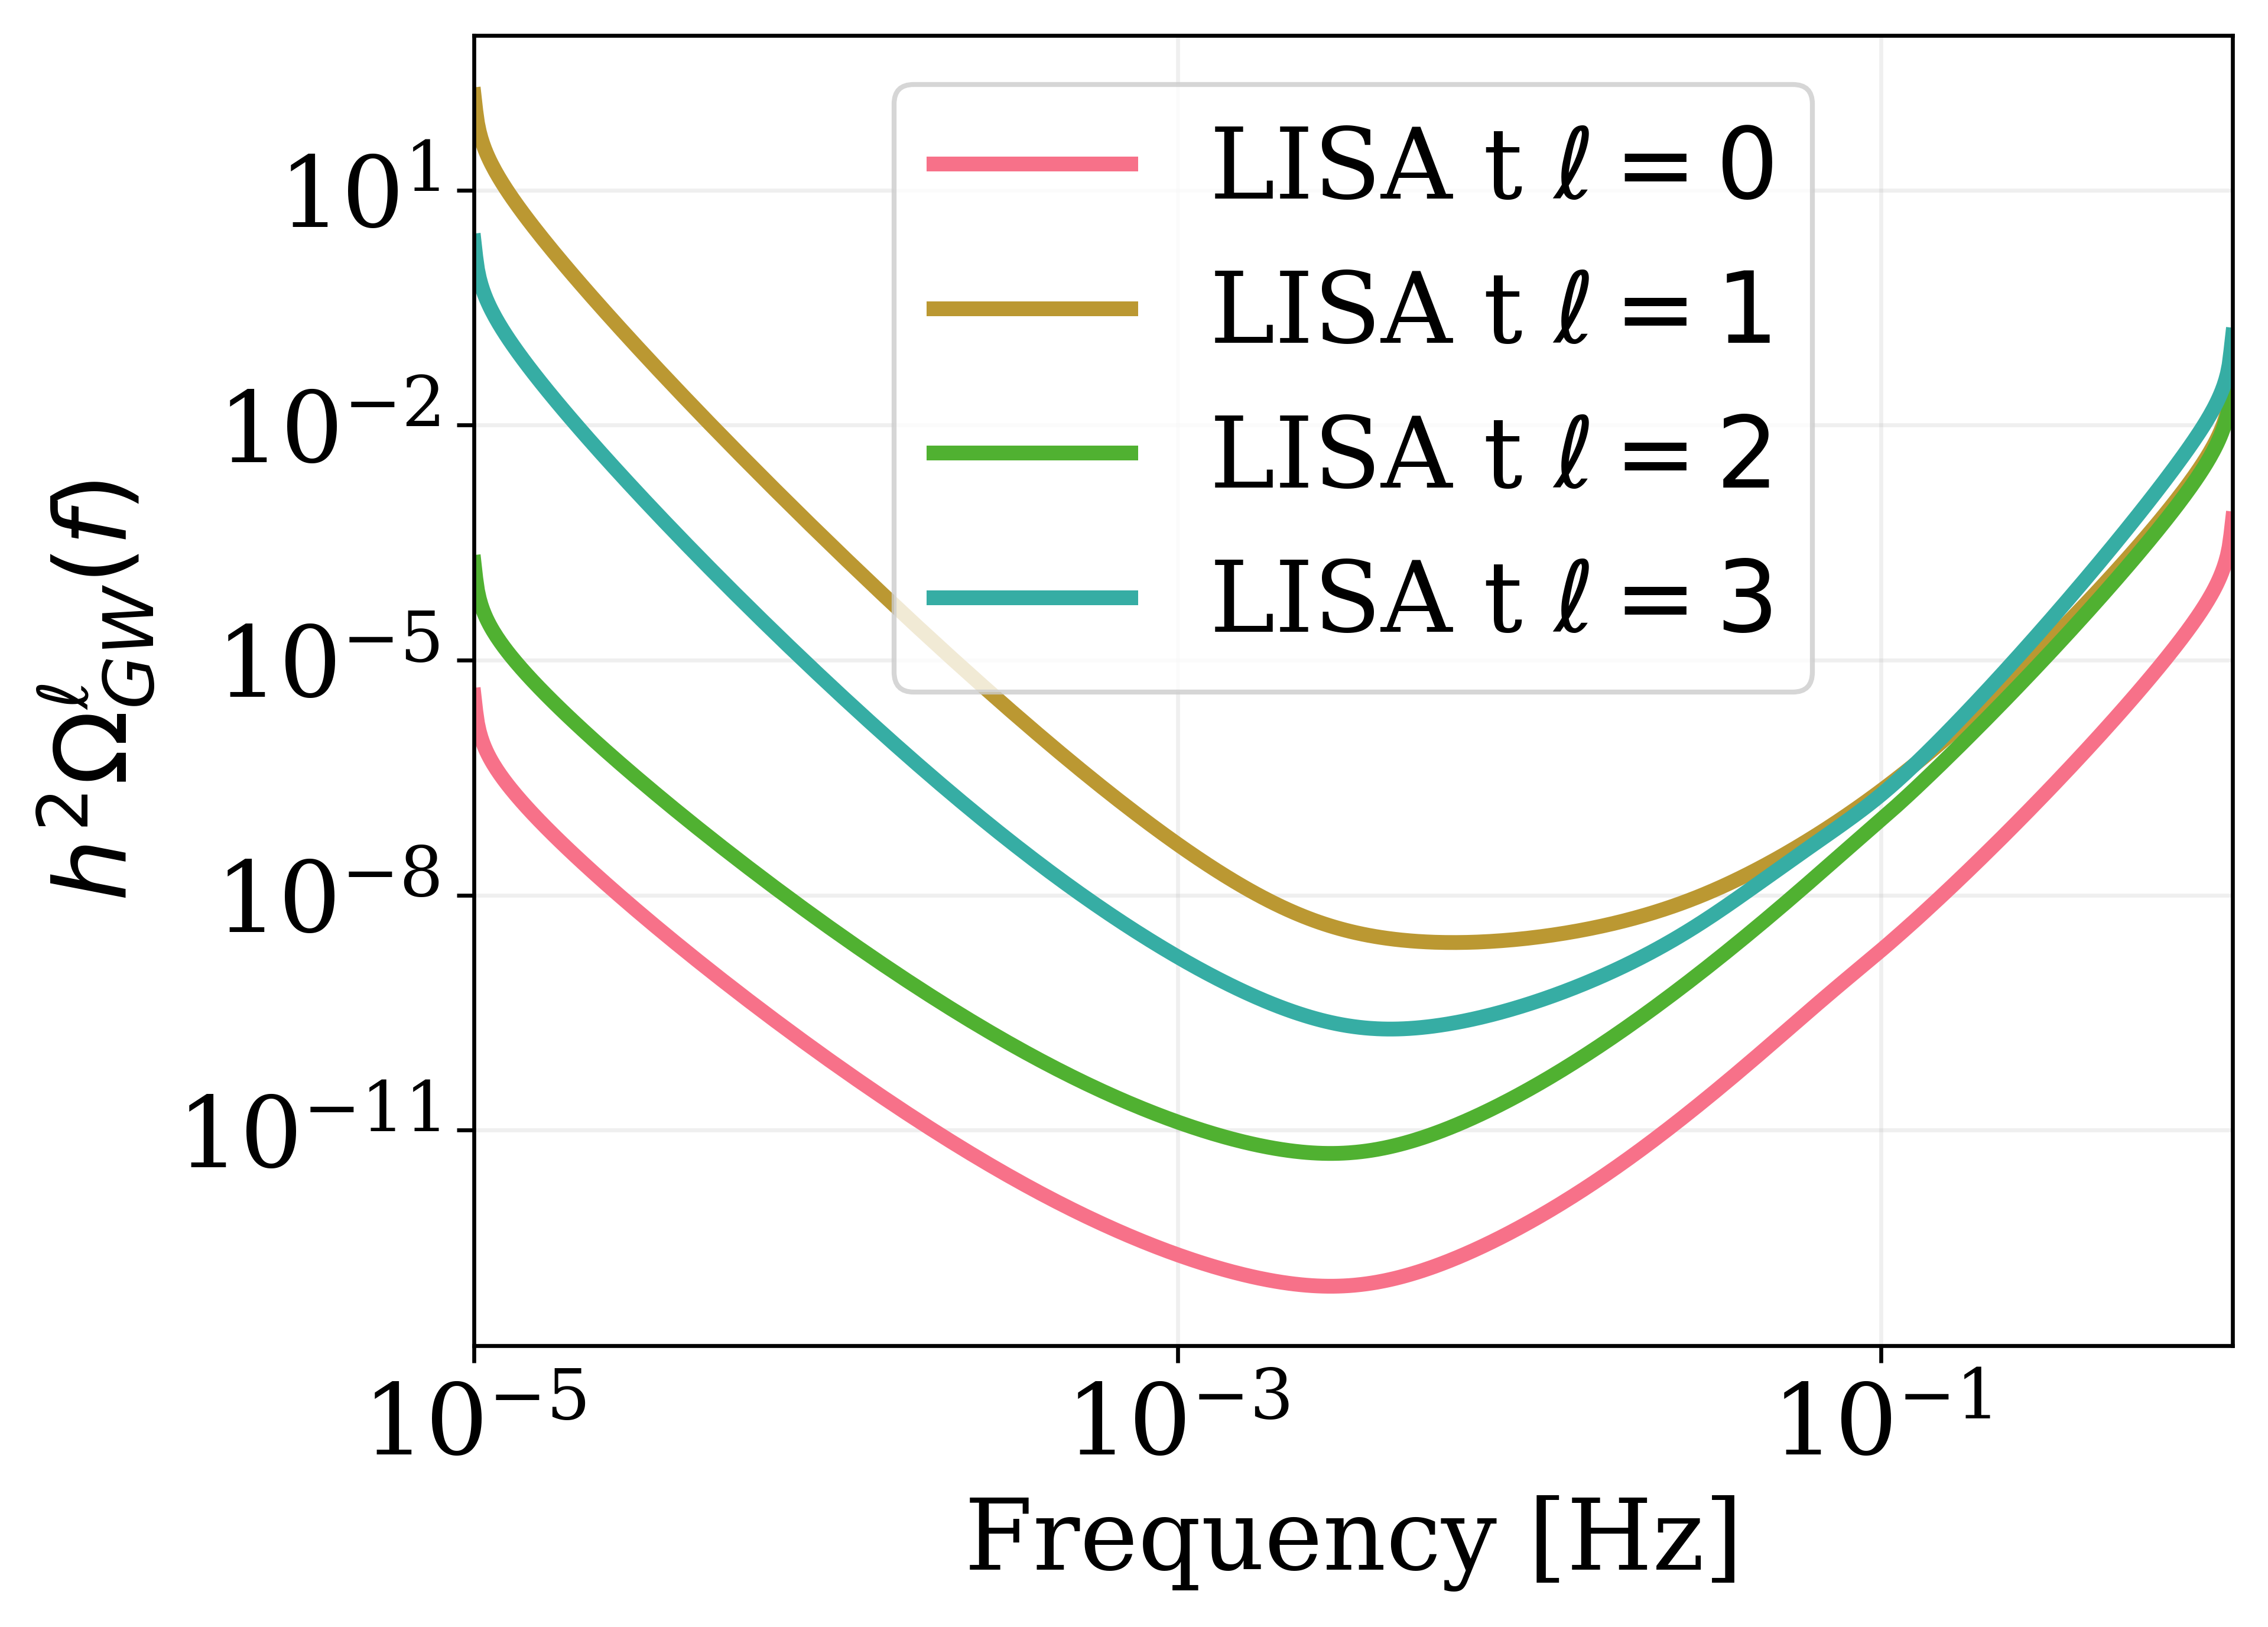

In [93]:
Tobs = 3
snr = 10
pls0_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 0, f_lisa, 't', 0, 1e-2, snr, Tobs, 1)
pls1_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 1, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
pls2_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 2, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
pls3_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 3, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)

plt.figure()
plt.plot(f_lisa, pls0_LISA, label='LISA t $\ell=0$')
plt.plot(f_lisa, pls1_LISA, label='LISA t $\ell=1$')
plt.plot(f_lisa, pls2_LISA, label='LISA t $\ell=2$')
plt.plot(f_lisa, pls3_LISA, label='LISA t $\ell=3$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.legend()



# Pulsar Timing Array

2025-03-12 15:45:23.947 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 15:45:36.011 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 15:45:48.067 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


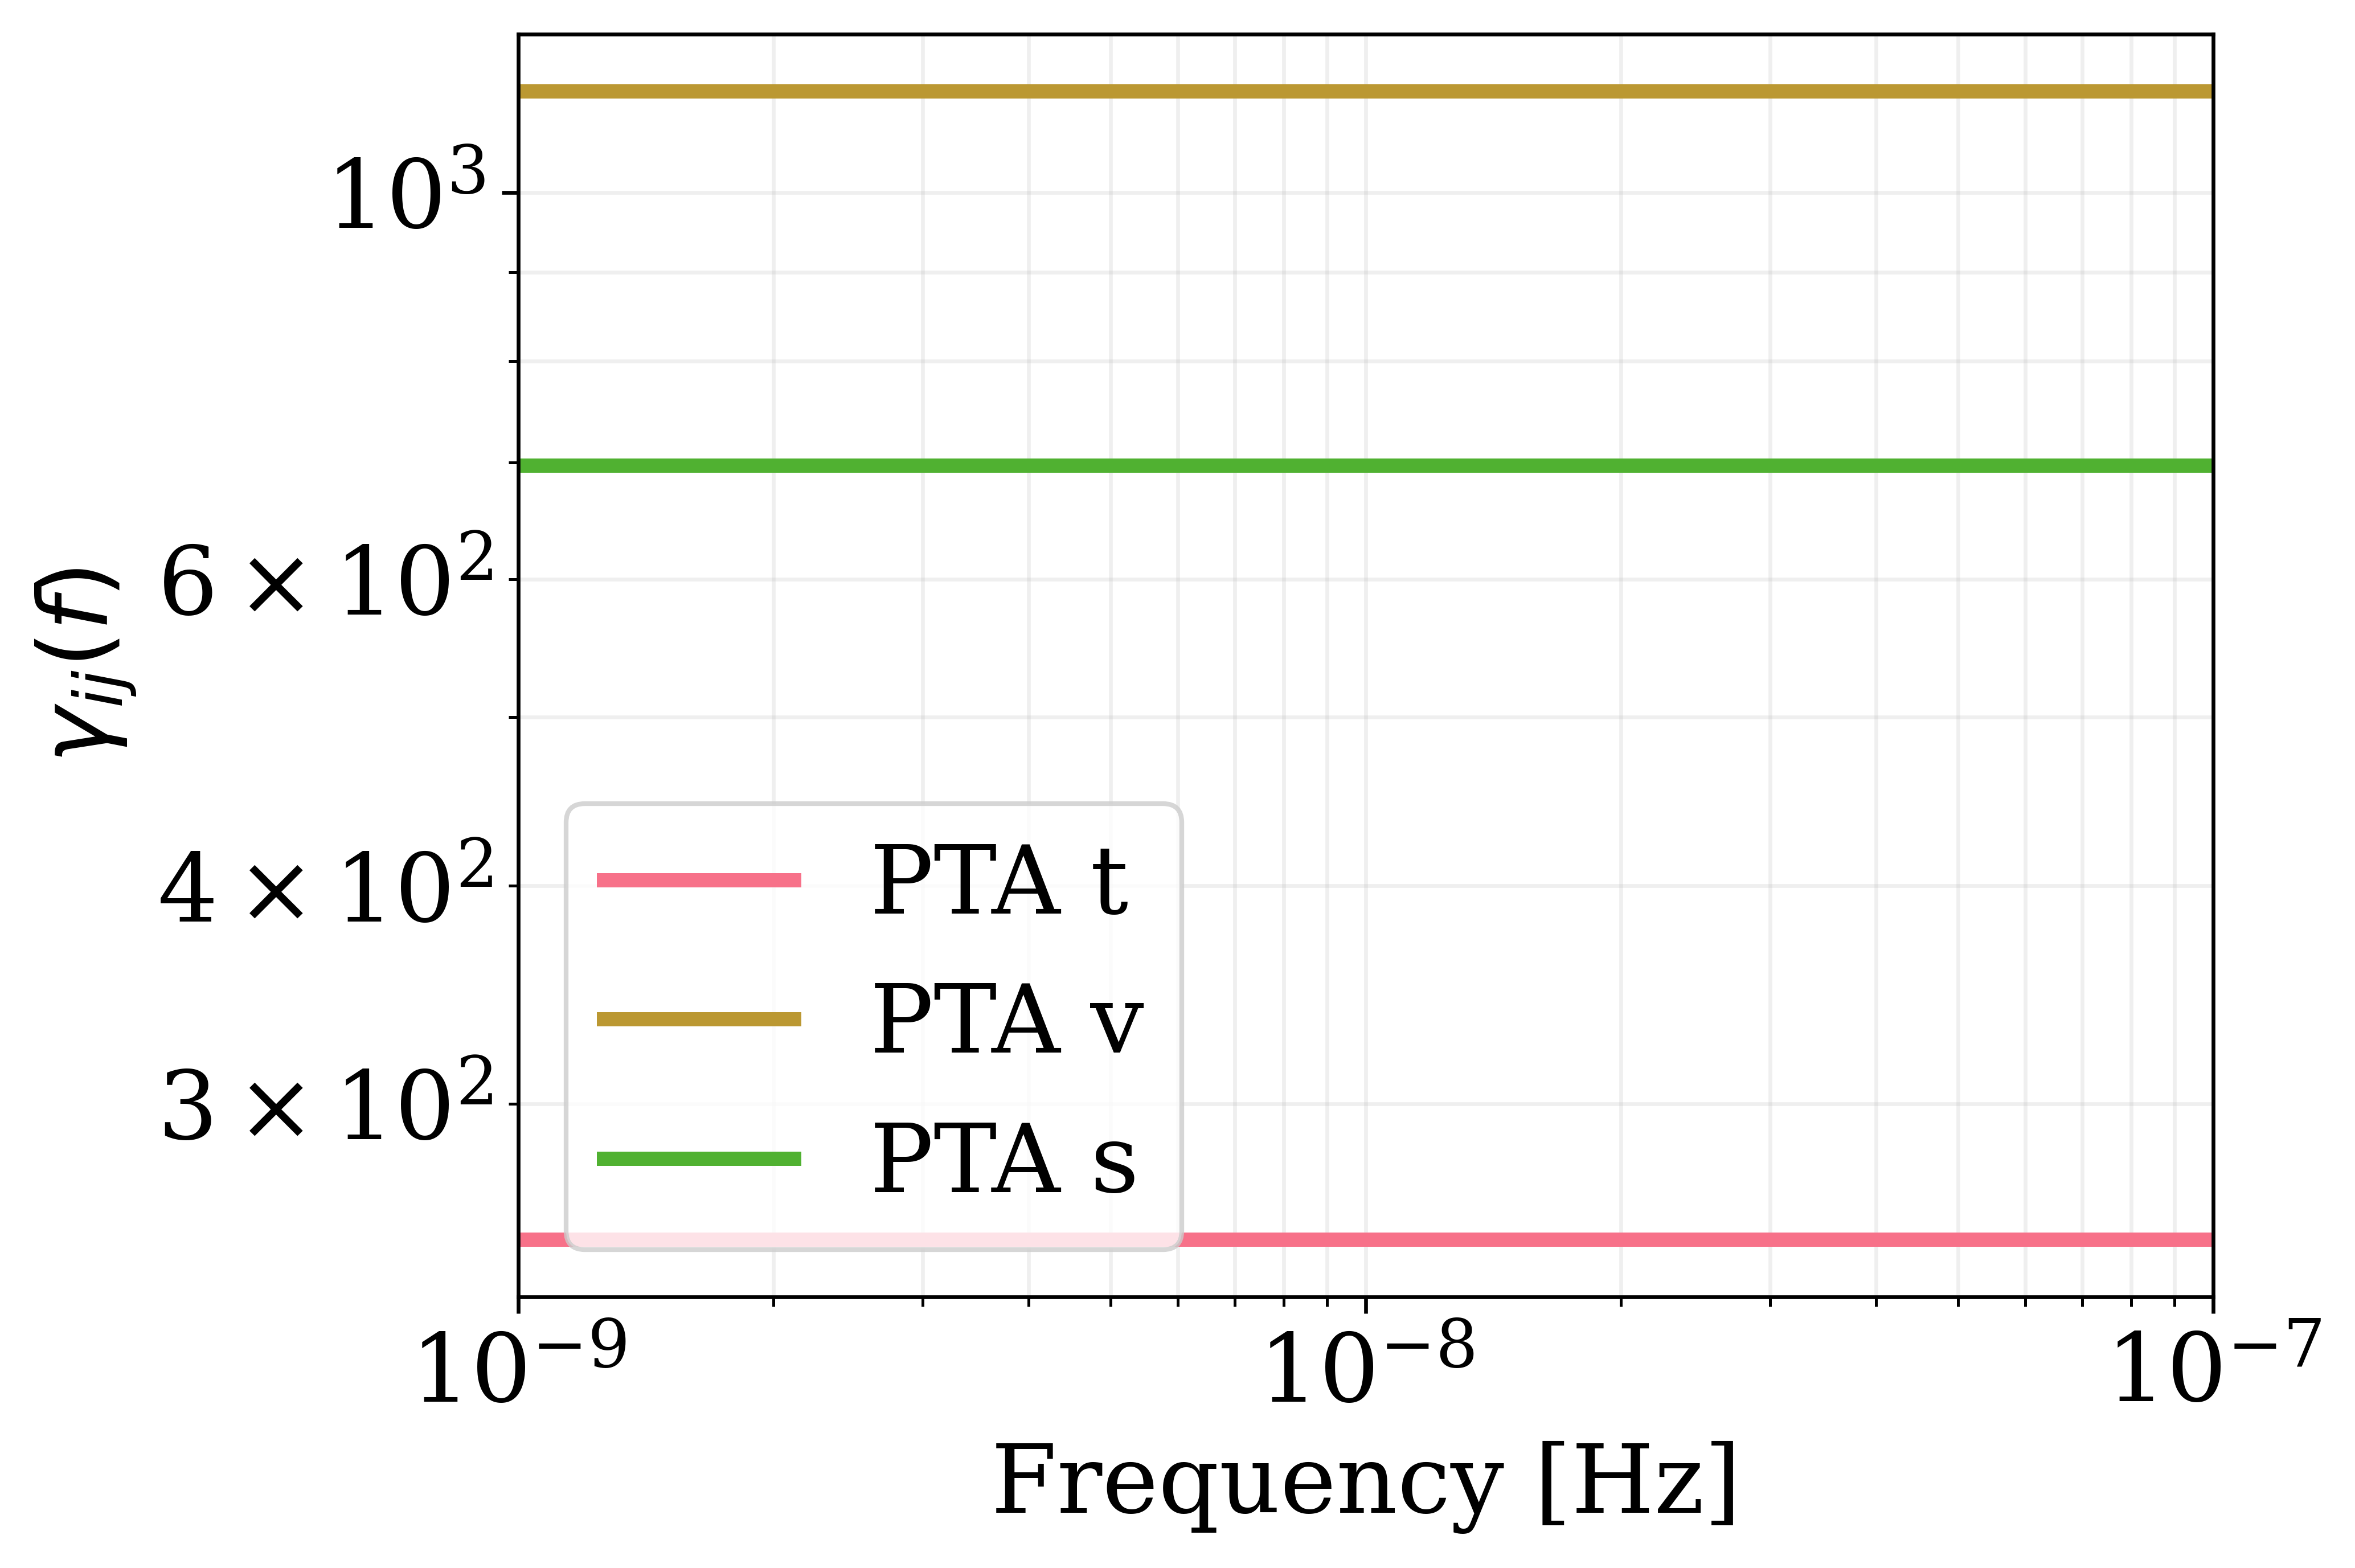

In [7]:
f = np.logspace(-9, -7, 100)
overlap_t_PTA = Response.overlap_PTA(f, 't')
overlap_v_PTA = Response.overlap_PTA(f, 'v')
overlap_s_PTA = Response.overlap_PTA(f, 's')

plt.plot(f, overlap_t_PTA, label='PTA t')
plt.plot(f, overlap_v_PTA, label='PTA v')
plt.plot(f, overlap_s_PTA, label='PTA s')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()

Angular PLS

2025-03-12 15:58:51.060 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 15:59:03.265 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


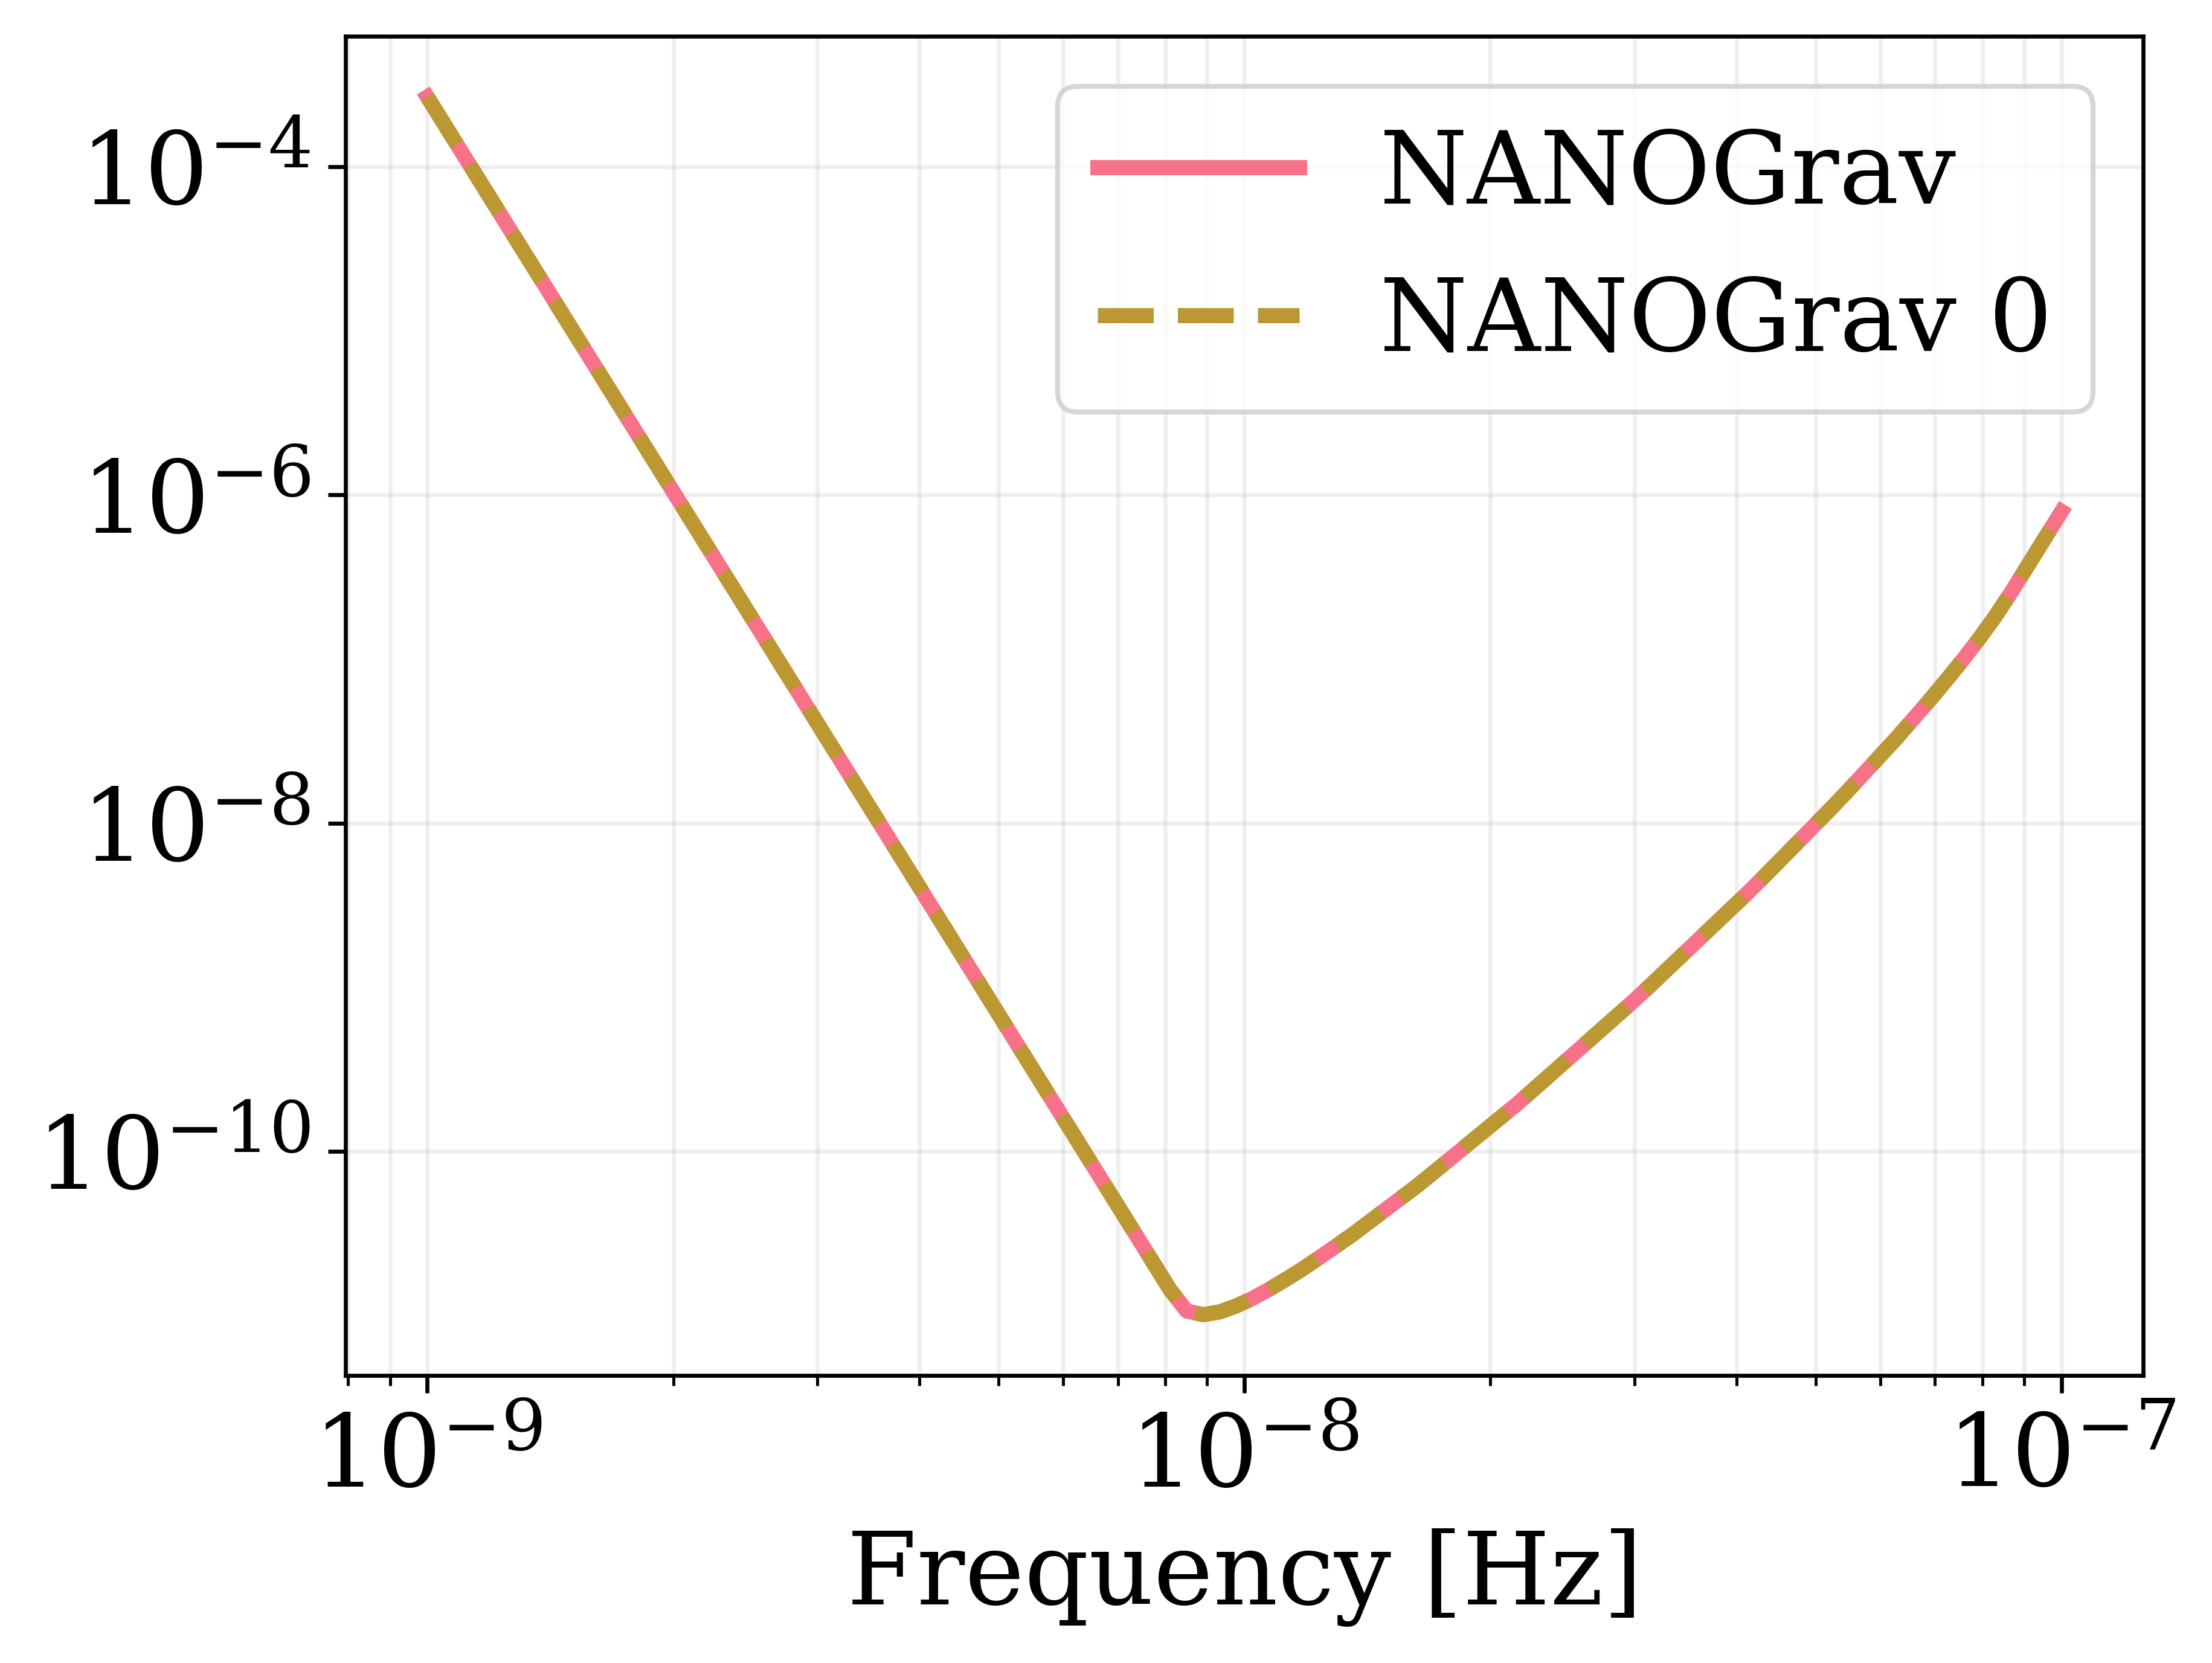

In [17]:
# check with the monopole
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 20
psi=0

pls_NANOGrav = pls.PLS_PTA(f, snr, Tobs, 't', psi)
pls_NANOGrav_0 = Sensitivity_ell.PLS_ell_PTA(0, f, snr, Tobs, 1, 't', psi)

plt.loglog(f, pls_NANOGrav, label='NANOGrav')
plt.loglog(f, pls_NANOGrav, label='NANOGrav 0', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid(which='both', alpha=0.2)
plt.show()

In [12]:
print(np.min(pls_NANOGrav))

1.0062053943971102e-11


2025-03-12 15:06:06.334 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


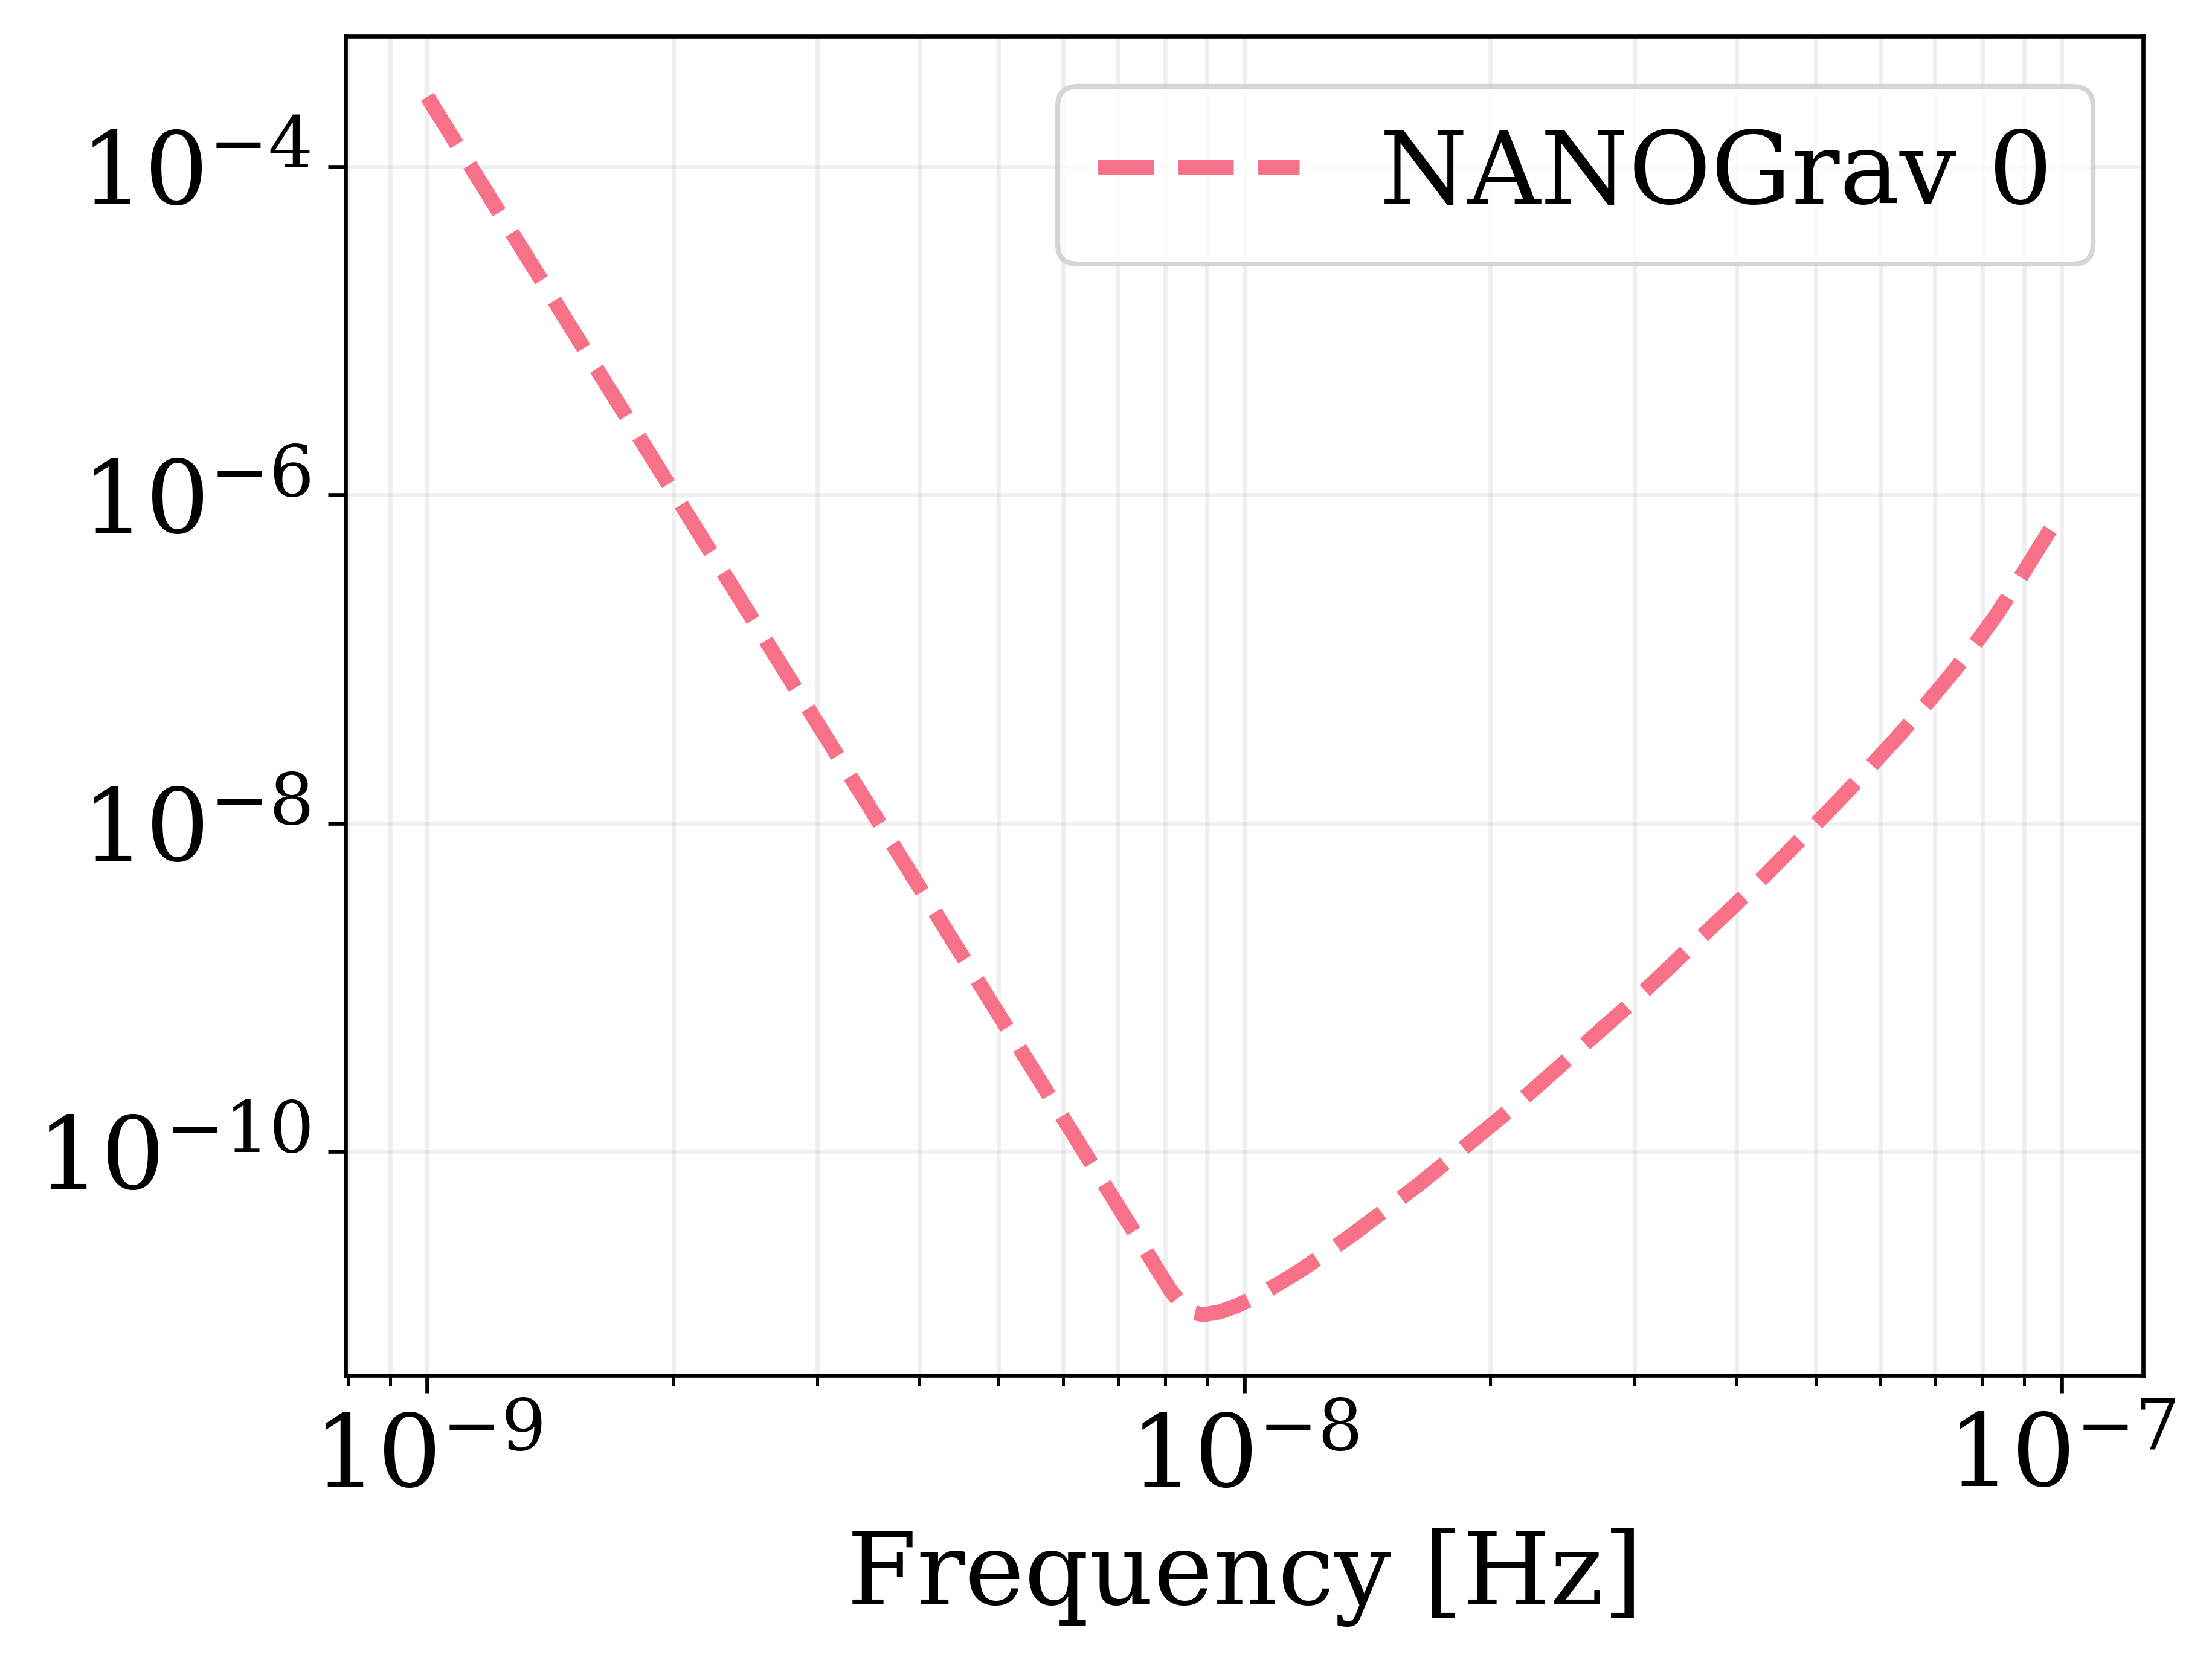

In [101]:
# check with the monopole
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 20
psi=0


pls_NANOGrav_0 = Sensitivity_ell.PLS_ell_PTA(0, f, snr, Tobs, 1, 't', psi)

plt.loglog(f, pls_NANOGrav, label='NANOGrav 0', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid(which='both', alpha=0.2)
plt.show()

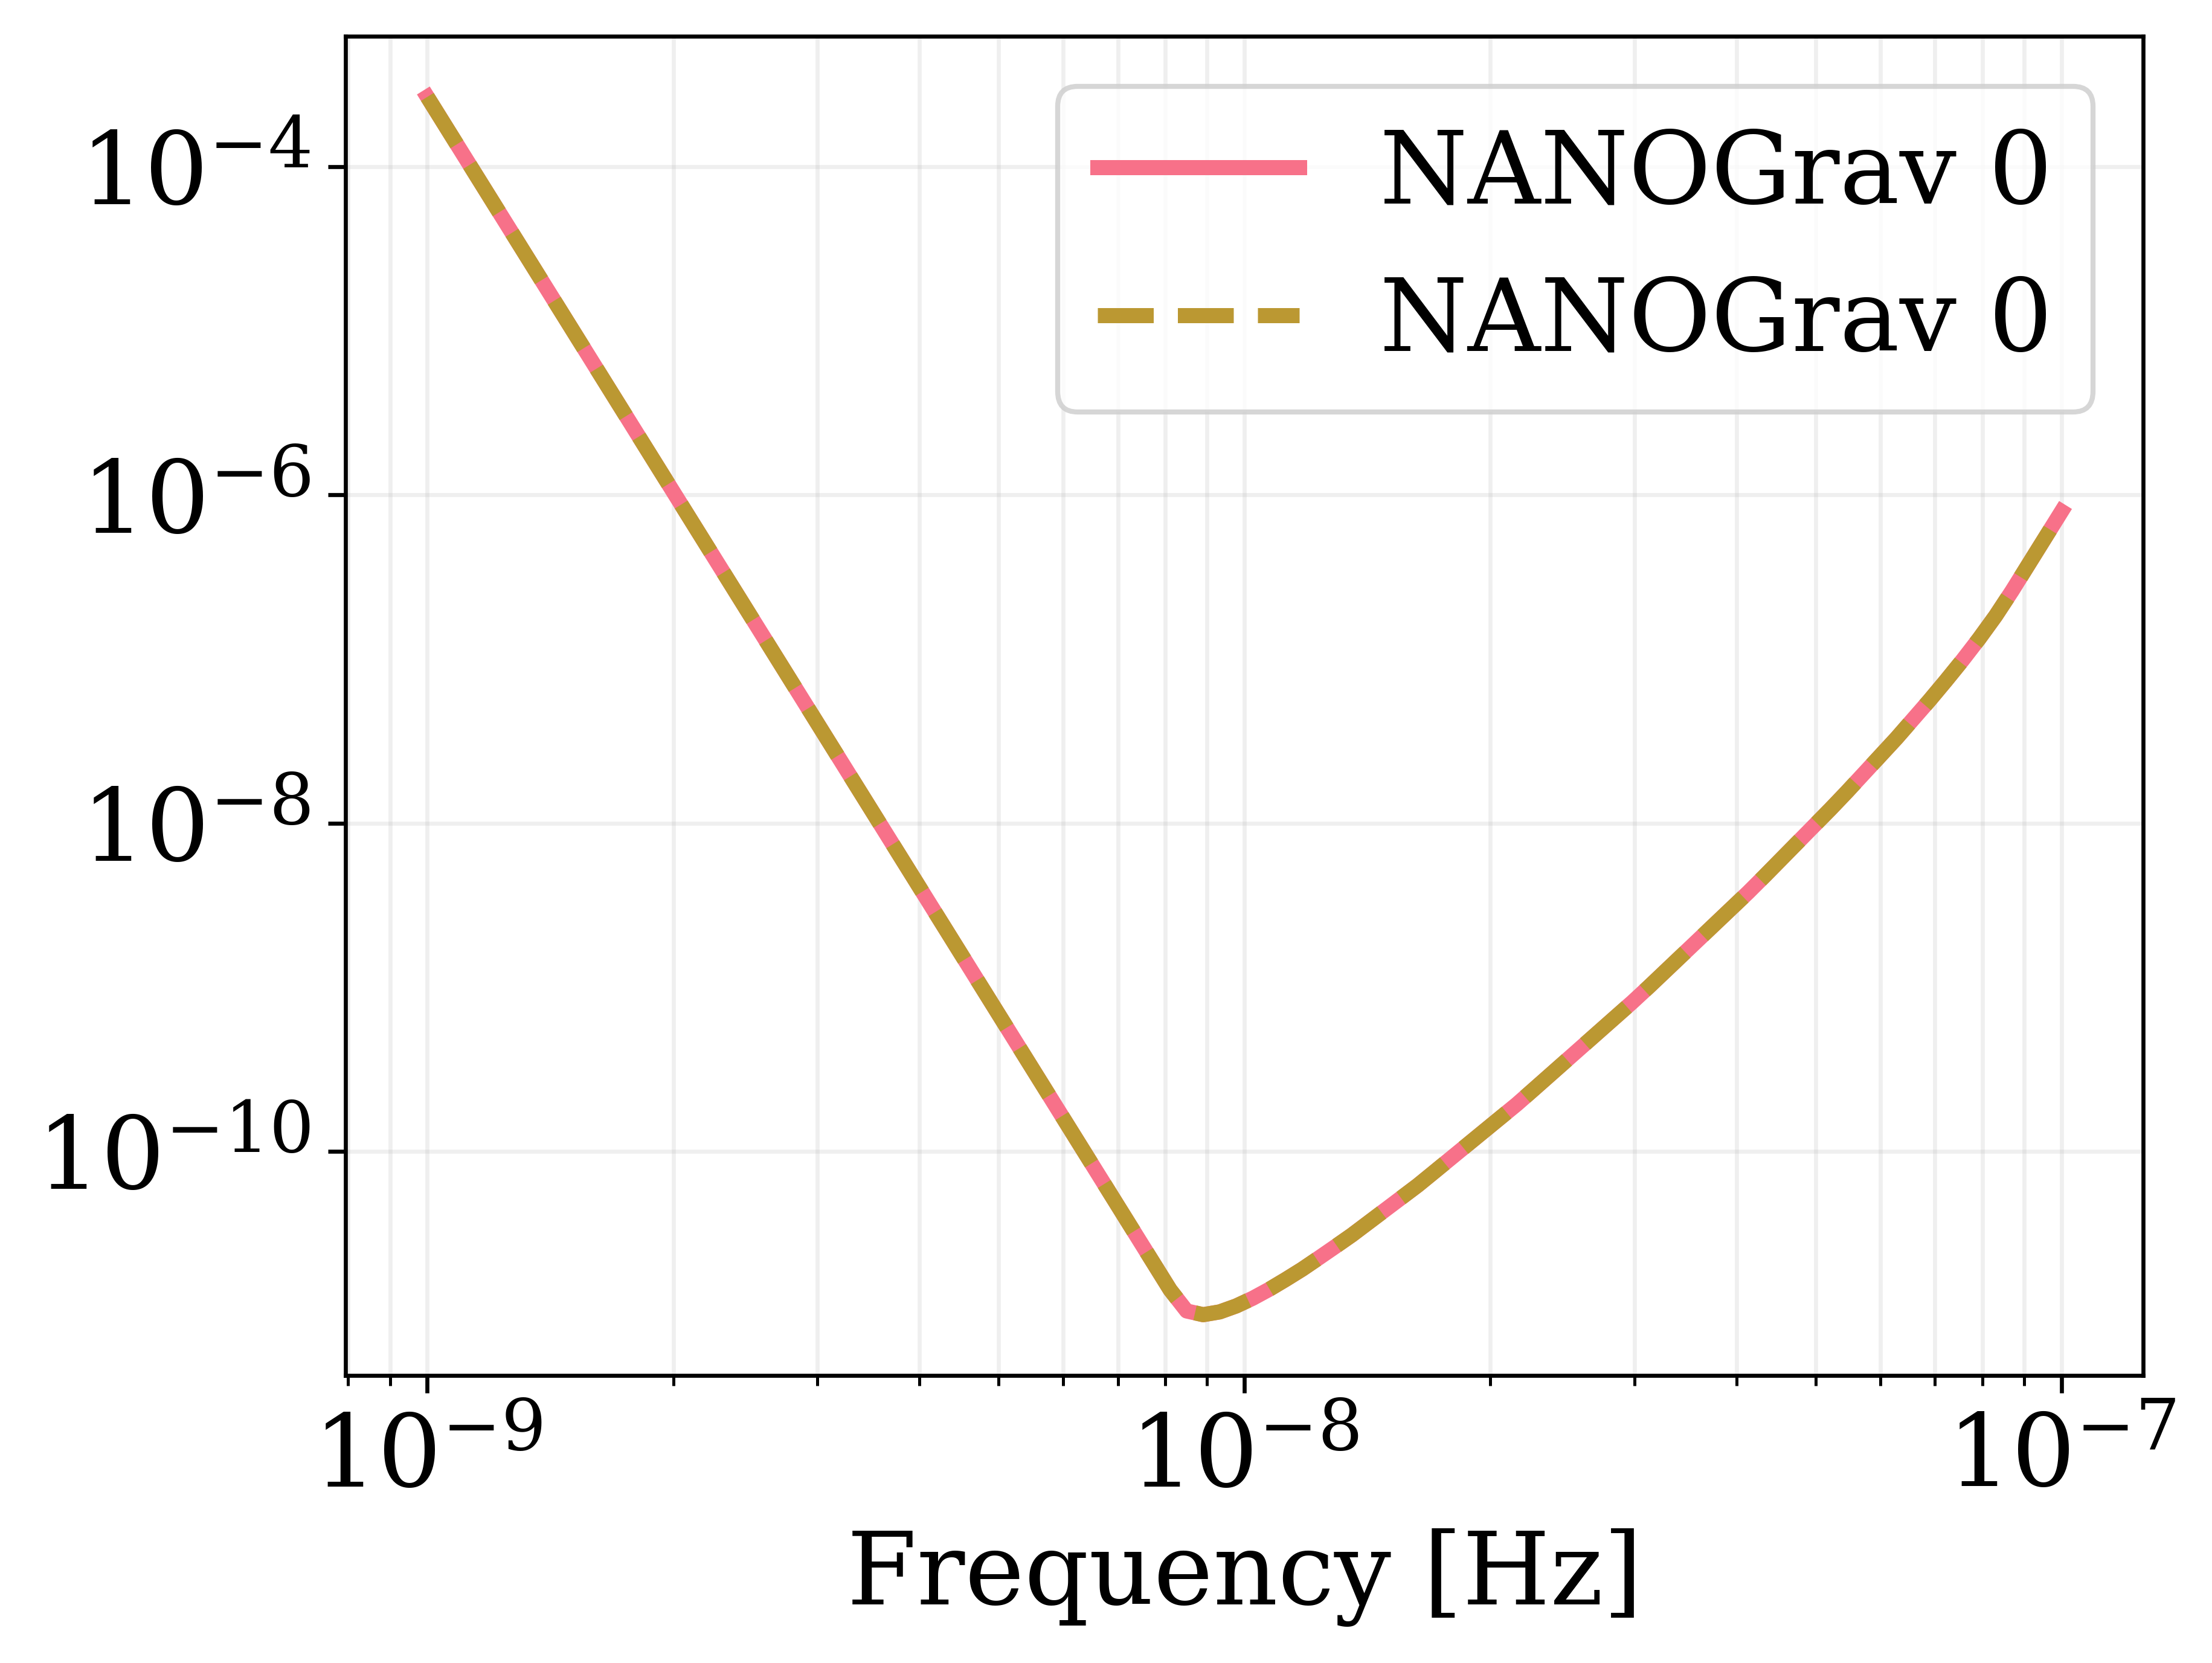

In [102]:
plt.loglog(f, pls_NANOGrav, label='NANOGrav 0')
plt.loglog(f, pls_NANOGrav_0, label='NANOGrav 0', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid(which='both', alpha=0.2)
plt.show()

In [18]:
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 20
psi=0

pls_NANOGrav_0 = Sensitivity_ell.PLS_ell_PTA(0, f, snr, Tobs, 1, 't', psi)
pls_NANOGrav_1 = Sensitivity_ell.PLS_ell_PTA(1, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_2 = Sensitivity_ell.PLS_ell_PTA(2, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_3 = Sensitivity_ell.PLS_ell_PTA(3, f, snr, Tobs, 1e-3, 't', psi)


2025-03-12 16:03:50.605 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 16:04:25.416 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 16:05:57.184 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-12 16:08:11.865 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


In [20]:
pls_NANOGrav_10 = Sensitivity_ell.PLS_ell_PTA(10, f, snr, Tobs, 1e-3, 't', psi)

2025-03-12 16:52:42.404 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


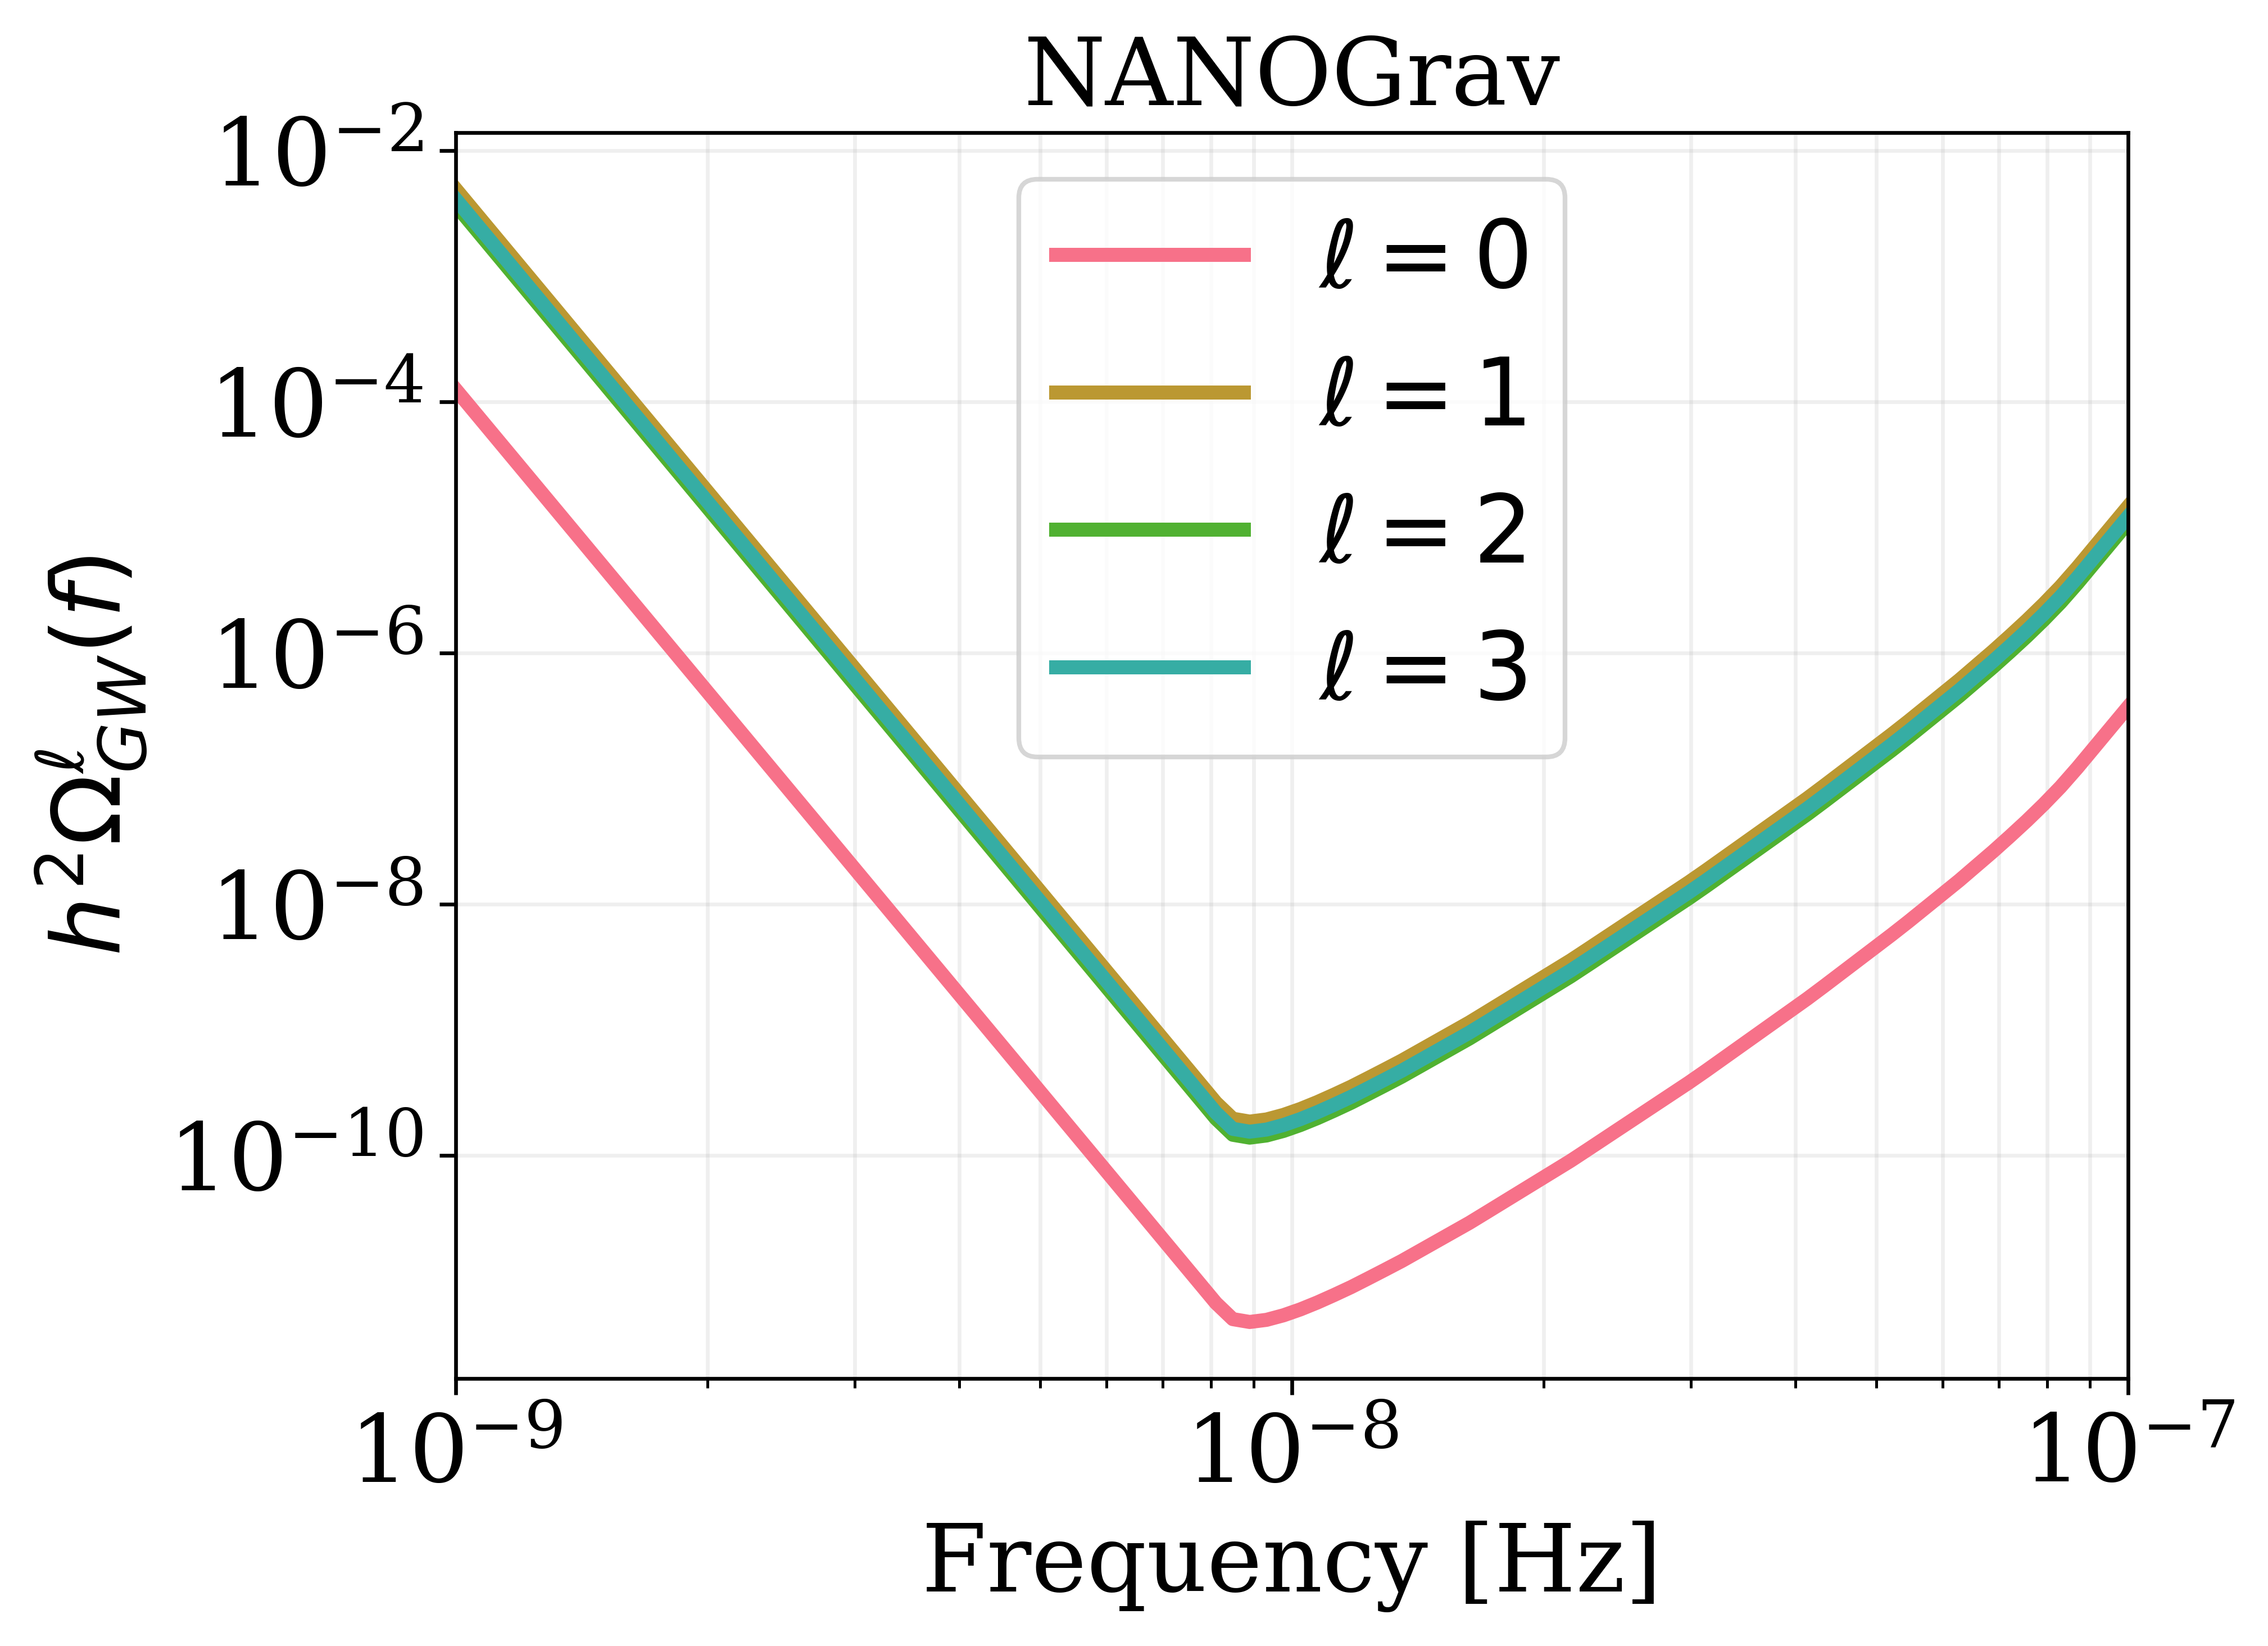

In [92]:
plt.loglog(f, pls_NANOGrav_0, label=r'$\ell=0$')
plt.loglog(f, pls_NANOGrav_1, label=r'$\ell=1$')
plt.loglog(f, pls_NANOGrav_2, label=r'$\ell=2$')
plt.loglog(f, pls_NANOGrav_3, label=r'$\ell=3$')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.title('NANOGrav')
plt.grid(which='both', alpha=0.2)

In [19]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

1.0062053943971106e-11
4.697716817075376e-10
3.2877088968145955e-10
3.905641875648467e-10


In [83]:
pls_EPTA_0 = Sensitivity_ell.PLS_ell_PTA_EPTA(0, f, snr, Tobs, 1, 't', psi)
pls_EPTA_1 = Sensitivity_ell.PLS_ell_PTA_EPTA(1, f, snr, Tobs, 1e-3, 't', psi)
pls_EPTA_2 = Sensitivity_ell.PLS_ell_PTA_EPTA(2, f, snr, Tobs, 1e-3, 't', psi)
pls_EPTA_3 = Sensitivity_ell.PLS_ell_PTA_EPTA(3, f, snr, Tobs, 1e-3, 't', psi)

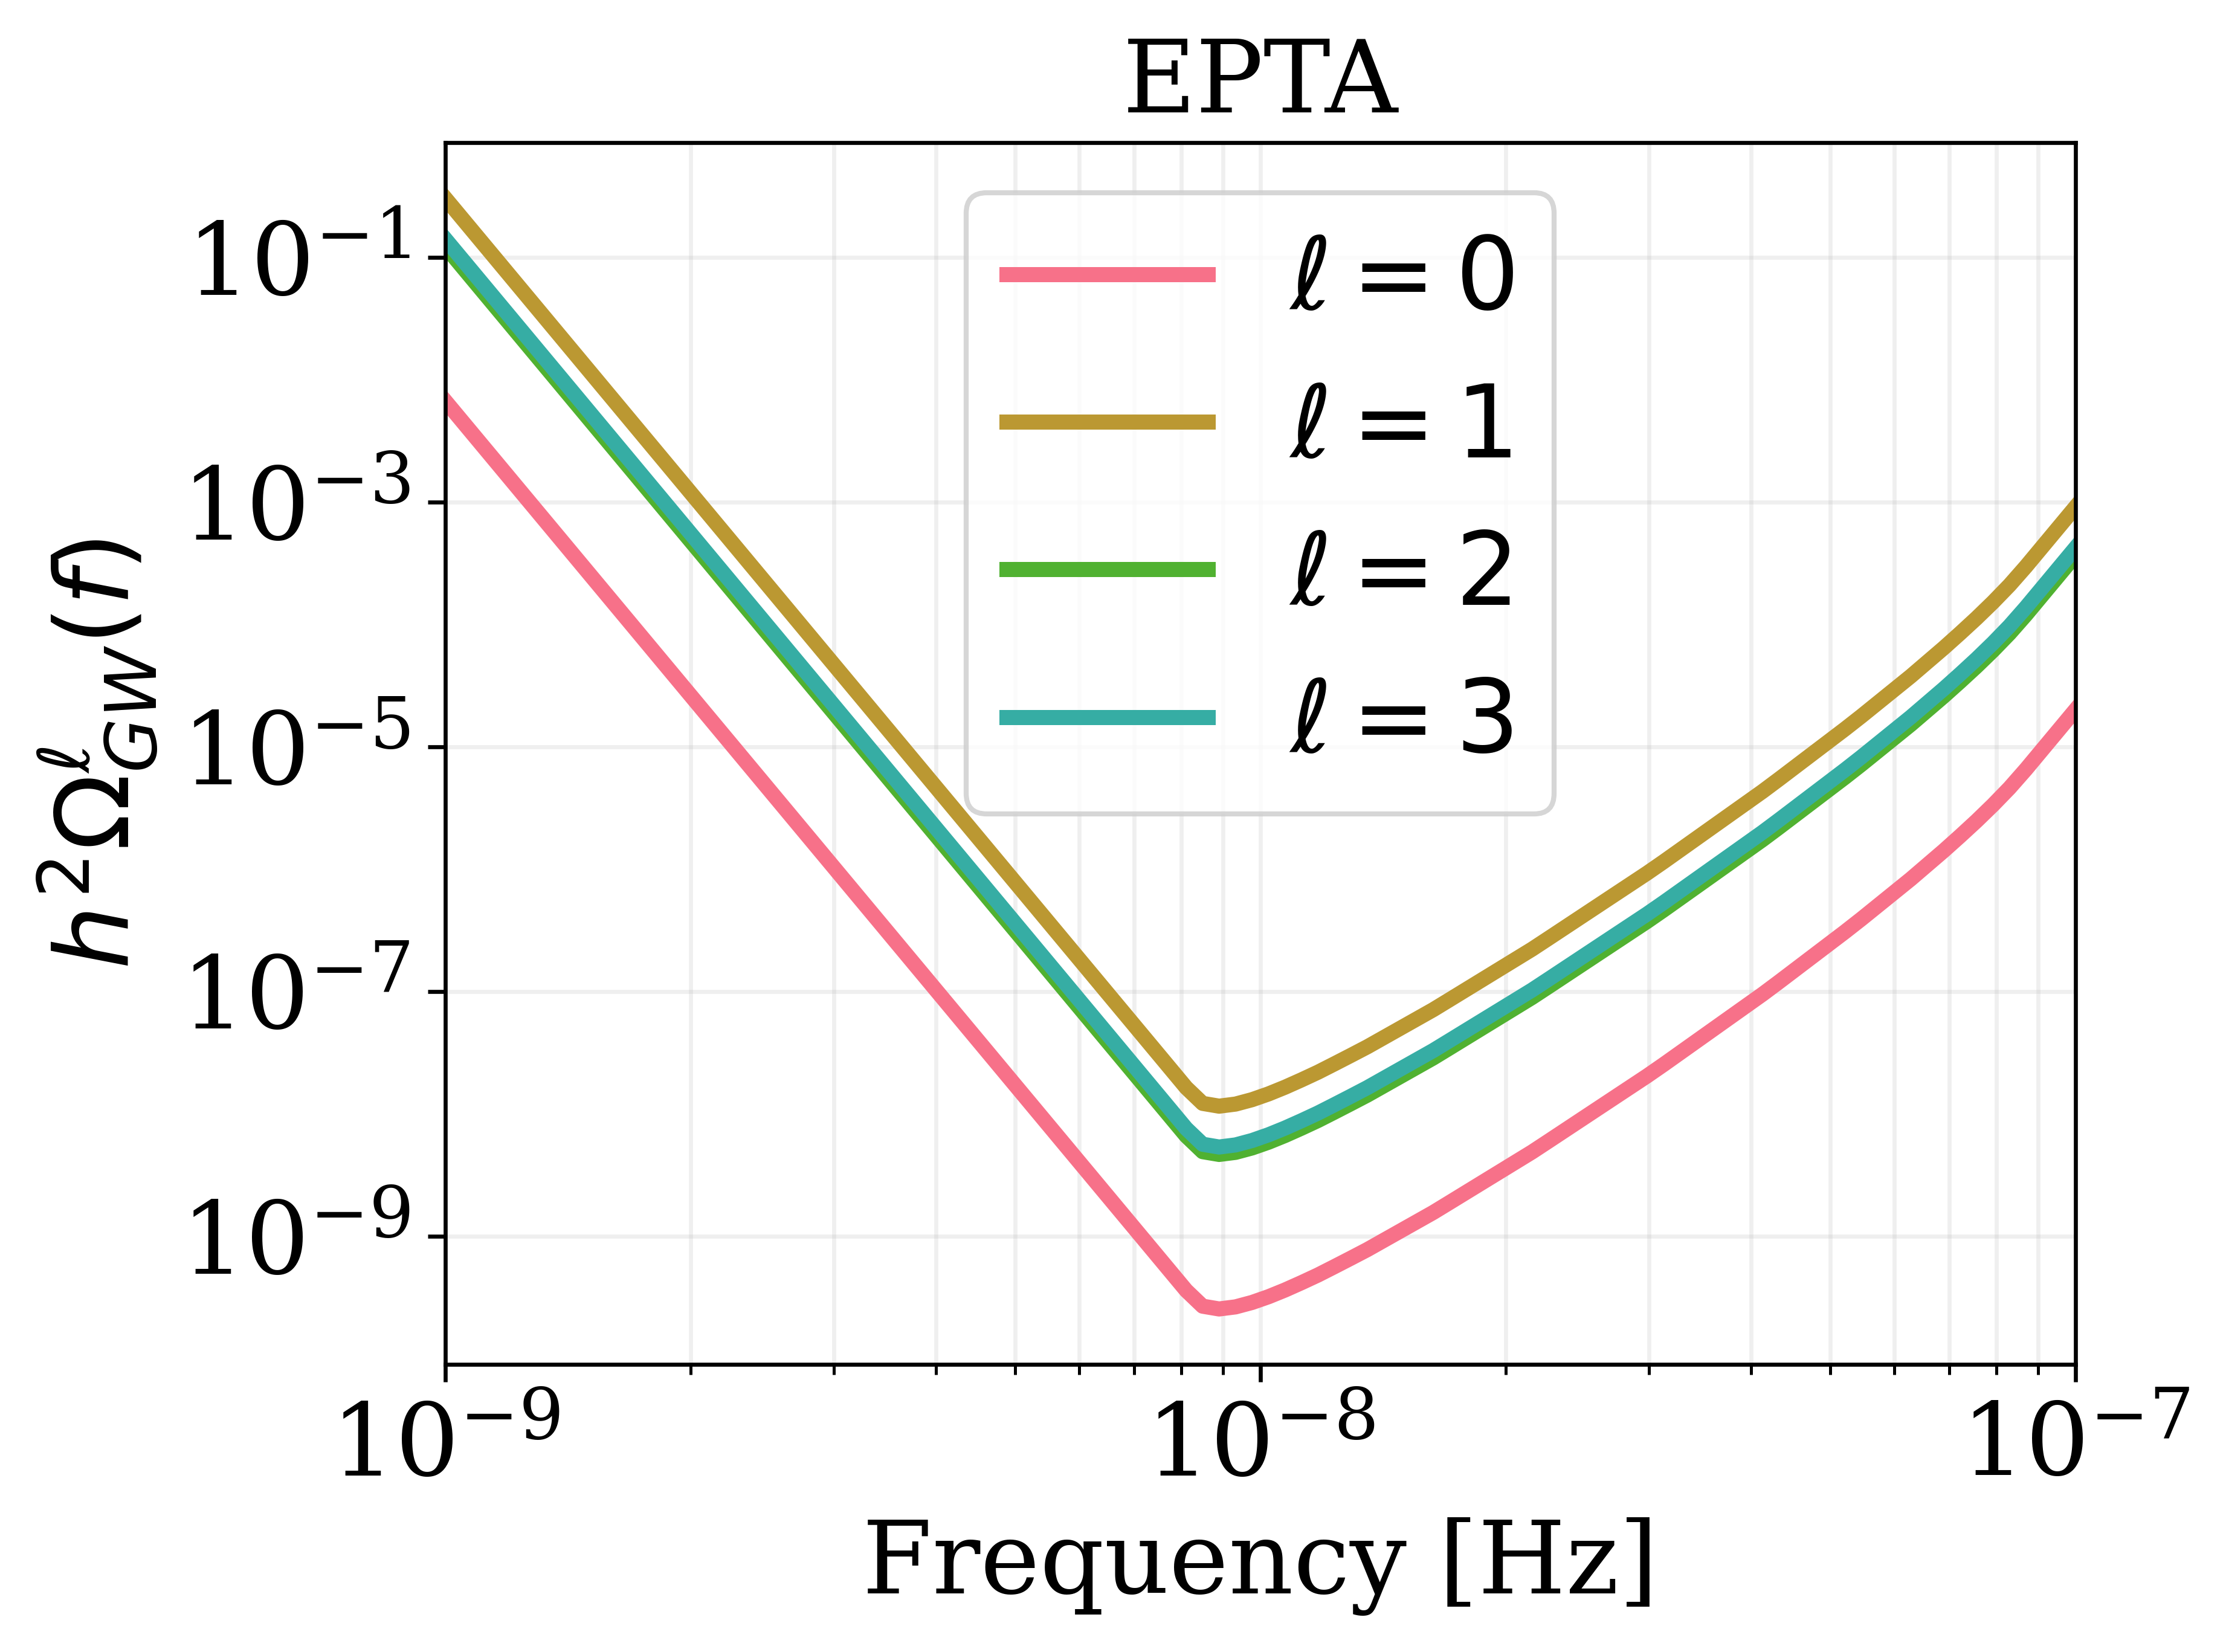

In [94]:
plt.loglog(f, pls_EPTA_0, label=r'$\ell=0$')
plt.loglog(f, pls_EPTA_1, label=r'$\ell=1$')
plt.loglog(f, pls_EPTA_2, label=r'$\ell=2$')
plt.loglog(f, pls_EPTA_3, label=r'$\ell=3$')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.legend()
plt.grid(which='both', alpha=0.2)
plt.title('EPTA')
plt.tight_layout()
plt.show()

In [95]:
print(np.min(pls_EPTA_0))
print(np.min(pls_EPTA_1))
print(np.min(pls_EPTA_2))
print(np.min(pls_EPTA_3))

2.538002831678964e-10
1.1547323247819355e-08
4.652958363575901e-09
5.350926052506975e-09
